In [1]:
import itertools
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import seaborn as sns

from statannotations.Annotator import Annotator


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()


In [5]:
from collections import defaultdict

data_dir = (Path().cwd().parents[0] / 'data').absolute()

# Get image dataframe 
df_imgs_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' / 'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_imgs_path)


In [6]:
sns.set_style('white')

# Initial statistics

In [7]:
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [8]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']


In [9]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)

In [10]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [11]:
# Filter out by maximum number of counts per cell
min_count = 100
max_count = 400

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

C:\Users\thu71\AppData\Local\Temp\ipykernel_48056\2224903840.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


Count_cell  Count_nuclei   Count_cyto
count  1347.000000   1347.000000  1347.000000
mean    353.522643    127.530809   225.991834
std     147.990578     52.440269   122.202566
min     101.000000      0.000000   -26.000000
25%     239.000000     94.000000   134.000000
50%     331.000000    124.000000   209.000000
75%     451.000000    157.500000   301.500000
max    1202.000000    423.000000  1202.000000

In [12]:
df_all = df_all[df_all['Count_cyto']>=0]

## Plots

In [13]:
def plot(plotting, figsize=(7,4)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [14]:
df_all['PPI'].unique()
df_all['PPI'] = df_all['PPI'].apply(lambda x: {'Cyclin D1 & CDK2': 'Cyclin D1 & CDK4', 'Cyclin E & CDK4':'Cyclin E & CDK2'}.get(x,x))

In [15]:
df_all['PPI'].unique()

array(['Bim & Tom20', 'Cyclin D1 & CDK4', 'Cyclin D1 & CDK2 - re',
       'Cyclin E & CDK2', 'Mcl-1 & BAK', 'NF-Kb & p-P90rsk',
       'NF-Kb & p-P90rsk - re', 'P-AKT & mTOR', 'Sox2 & Oct4',
       'TEAD1 & YAP', 'p-ERK & c-MYC'], dtype=object)

In [16]:
df_all = df_all[~df_all['PPI'].isin(['NF-Kb & p-P90rsk - re', 'Cyclin D1 & CDK2 - re'])]

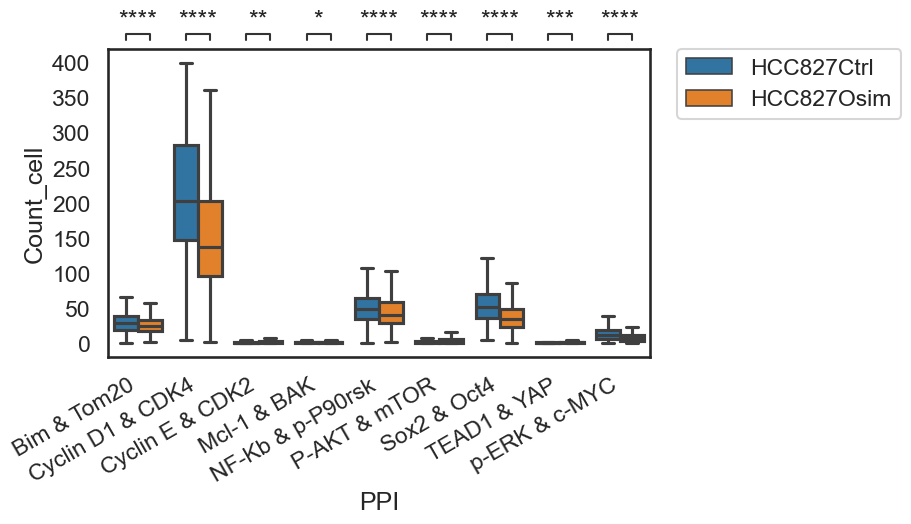

In [17]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

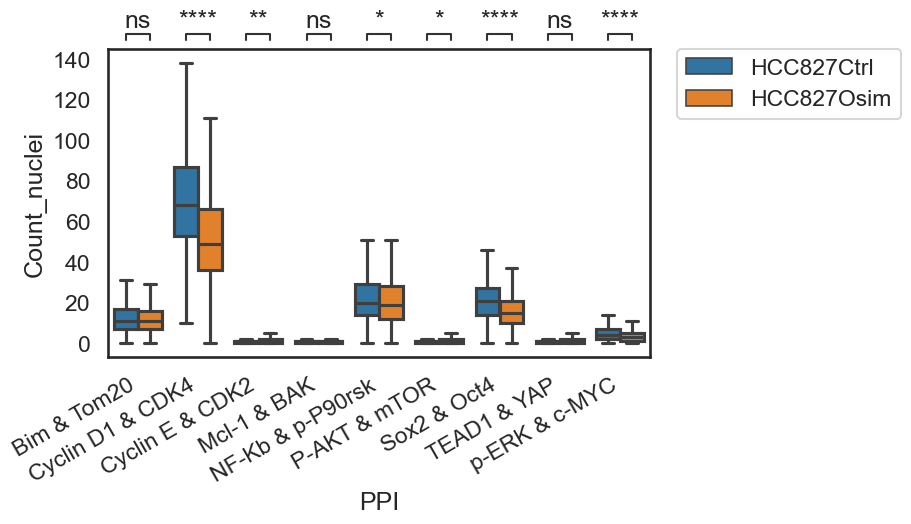

In [18]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

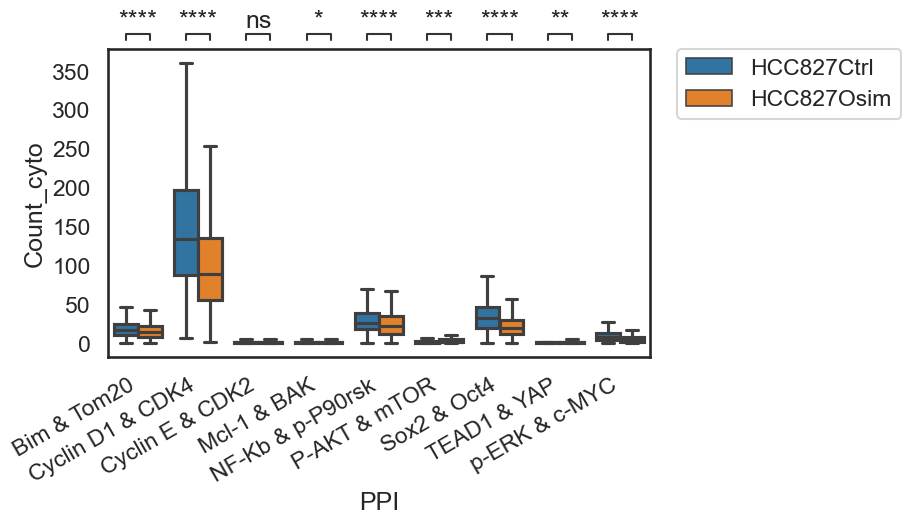

In [19]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-ERK & c-MYC_Count_nuclei vs. p-ERK & c-MYC_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:8.617e-42 U_stat=1.443e+05
Cyclin D1 & CDK4_Count_nuclei vs. Cyclin D1 & CDK4_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.108e-96 U_stat=9.812e+04
Bim & Tom20_Count_nuclei vs. Bim & Tom20_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.685e-29 U_stat=1.740e+05
Cyclin E & CDK2_Count_nuclei vs. Cyclin E & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:5.721e-01 U_stat=4.108e+04
Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.776e-09 U_stat=9.794e+04
NF-Kb & p-P90rsk_Count_nuclei vs. NF-Kb & p-P90rsk_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.296e-18 U_stat=1.949e+05
P-AKT & mTOR_Count_nuclei vs. P-

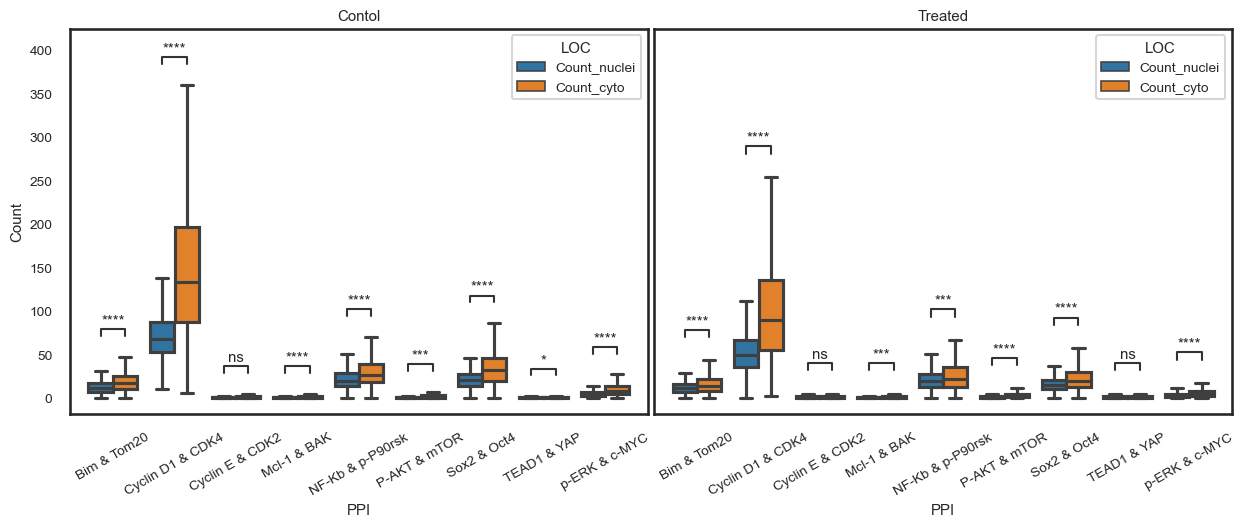

In [20]:
# Boxplot per loc
df_melt = df_all.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


df_melt['Count'] = df_melt['Count'].clip(0, upper=None)

with sns.plotting_context('talk', font_scale=0.6):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == 'HCC827Ctrl']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == 'HCC827Osim']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)

In [21]:
df_all = df_all[~df_all['PPI'].isin(['Cyclin D1 & CDK4'])]

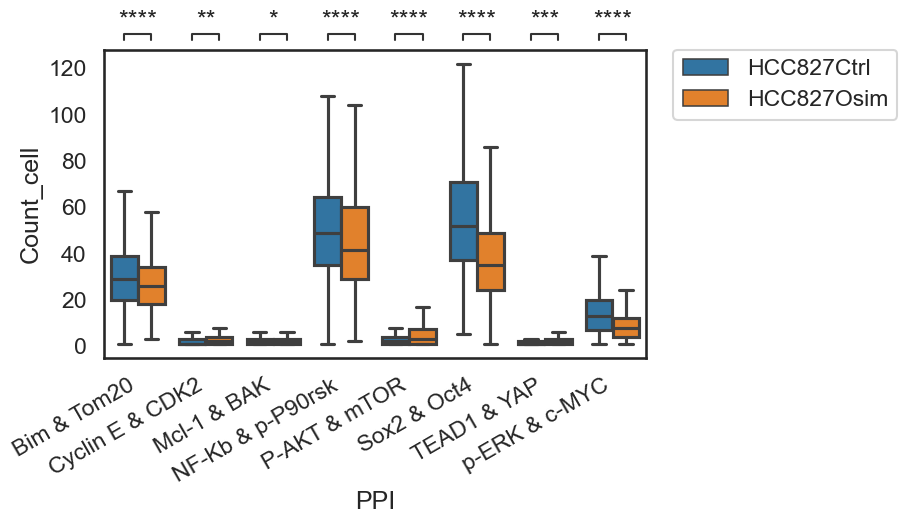

In [22]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

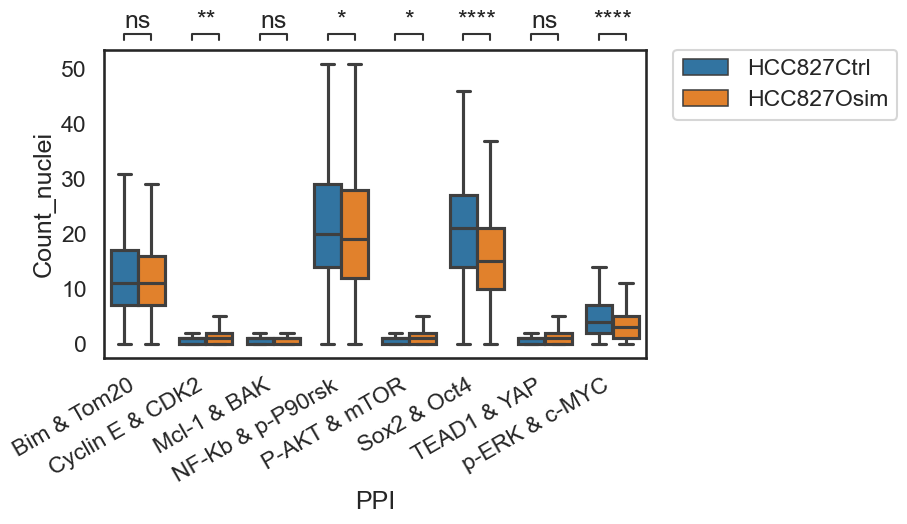

In [23]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

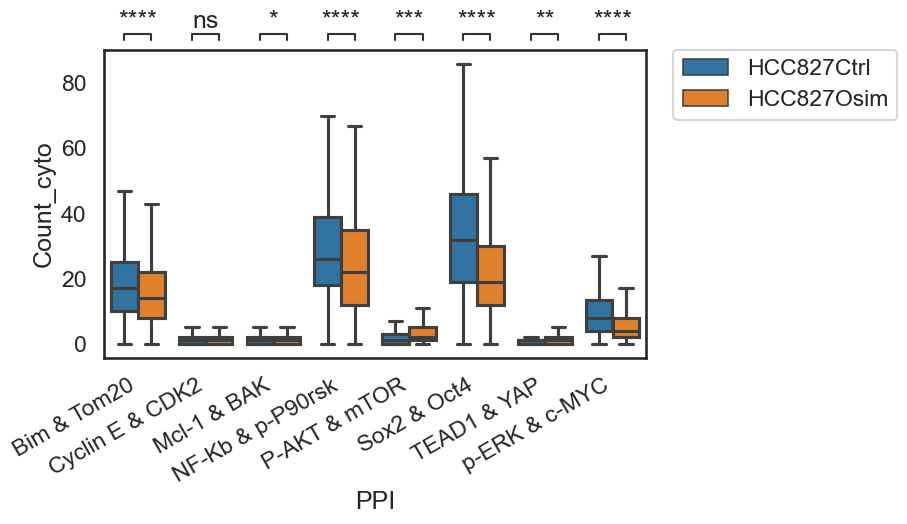

In [24]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E & CDK2_Count_nuclei vs. Cyclin E & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:5.721e-01 U_stat=4.108e+04
Bim & Tom20_Count_nuclei vs. Bim & Tom20_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.685e-29 U_stat=1.740e+05
Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.776e-09 U_stat=9.794e+04
NF-Kb & p-P90rsk_Count_nuclei vs. NF-Kb & p-P90rsk_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.296e-18 U_stat=1.949e+05
P-AKT & mTOR_Count_nuclei vs. P-AKT & mTOR_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.120e-04 U_stat=2.443e+04
Sox2 & Oct4_Count_nuclei vs. Sox2 & Oct4_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:7.892e-43 U_stat=1.545e+05
TEAD1 & YAP_Count_nuclei vs. TEAD1 & YAP_Cou

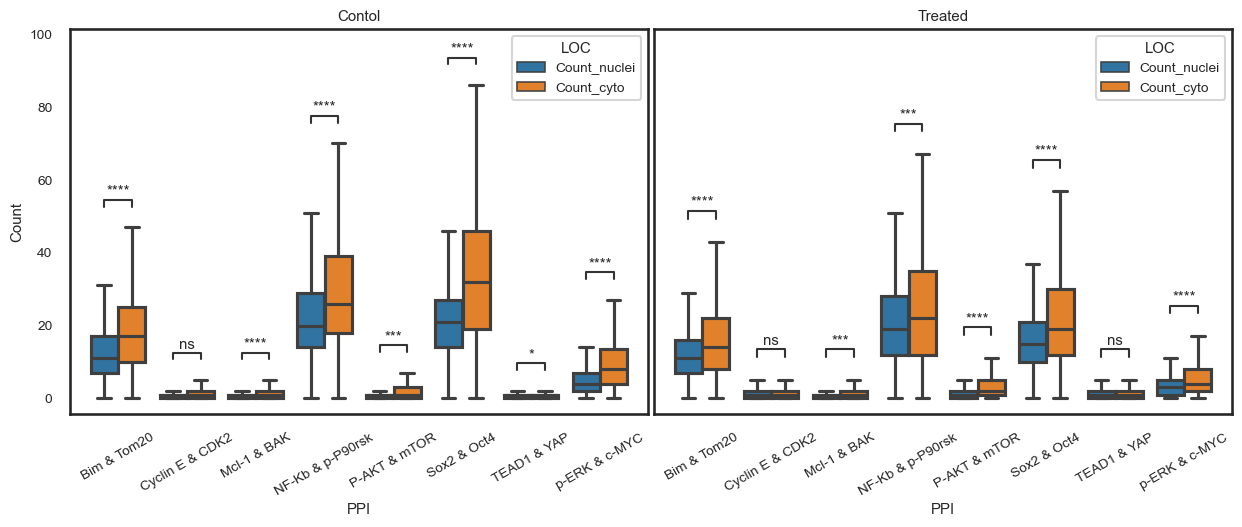

In [25]:
# Boxplot per loc
df_melt = df_all.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


df_melt['Count'] = df_melt['Count'].clip(0, upper=None)

with sns.plotting_context('talk', font_scale=0.6):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == 'HCC827Ctrl']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == 'HCC827Osim']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)

# Coexpression with other markers

## Extract mean expresion around PPI dots

In [26]:
from functools import partial

def read_mean_pixels(x, y, window_size, path):
    x_min = np.clip(x-window_size,a_min=0, a_max=None)
    x_max = x+window_size
    y_min = np.clip(y-window_size, a_min=0, a_max=None)
    y_max = y+window_size
    
    with h5py.File(path, "r") as f:
        pixels = f['imgs'][:, y_min:y_max, x_min:x_max]
    mean_expression = pixels.mean(axis=(1,2))
    return mean_expression
    
def extract(df, path, window_size=5):
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    
    # Read markers name 
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
    
    # Define partial and joblib
    read_partial = partial(read_mean_pixels, window_size=window_size, path=path)
    mean_expressions = Parallel(n_jobs=20)(delayed(read_partial)(i,j) for i,j in zip(y,x))
    
    # create dataframe
    _, indices = np.unique(markers, return_index=True)
    indices.sort()
    marker_unique = markers[indices]
    mean_expressions = np.stack(mean_expressions)
    df_exp = pd.DataFrame(mean_expressions[:, indices], columns=marker_unique)
    return df_exp

In [27]:
# Read PPI data
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)
df_fil = df[df.Cyto > 0]

In [28]:
# # Get Co-expression data
# PPI_exp_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI' / 'expression'
# PPI_exp_path.mkdir(parents=True, exist_ok=True)

# group = df_fil.groupby(['Condition', 'FOV'])

# for name, df_group in group:
#     path = df_imgs[(df_imgs.Timepoint == name[0]) & (df_imgs.FOV == name[1])].Path.item()
#     df_expression = extract(df_group, path)
    
#     df_merged = pd.concat([df_group.reset_index().rename({'index':'Original Index'}, axis=1), 
#                            df_expression], axis=1)
    
#     # Save coexpression
#     file_name = '_'.join(name)
#     save_path = PPI_exp_path / f'{file_name}.csv'
#     df_merged.to_csv(save_path)

## PPI co-expression boxplot

In [29]:
def plot(plotting, ):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=(15,3))
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.barplot(**plotting, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        
def plot(plotting, ax):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]


    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
    result = annot.apply_test().annotate()
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)


In [30]:
# Read PPI data
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI' / 'expression'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path, index_col=0)
        dfs.append(df)

df_exp = pd.concat(dfs)
df_exp = df_exp.rename(columns = {'Cyclin D1 & CDK2': 'Cyclin D1 & CDK4', 'Cyclin E & CDK4':'Cyclin E & CDK2'})
df_exp['PPI'] = df_exp['PPI'].apply(lambda x: {'Cyclin D1 & CDK2': 'Cyclin D1 & CDK4', 'Cyclin E & CDK4':'Cyclin E & CDK2'}.get(x,x))

In [31]:
df_exp.columns

Index(['Original Index', 'Cyto', 'x', 'y', 'PPI', 'Nuclei', 'Condition', 'FOV',
       'Hoeschst', 'Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK2', 'P-AKT & mTOR', 'p-EGFR', 'Phalloidin', 'Ki67',
       'Cyclin D1 & CDK2 - re', 'NF-Kb & p-P90rsk - re', 'NBD-C6', 'Golph4',
       'COX IV', 'Pan-cytokeratin', 'Concanavalin A', 'WGA'],
      dtype='object')

In [32]:
df_exp = df_exp[~df_exp['PPI'].isin(['Cyclin D1 & CDK2 - re',  'NF-Kb & p-P90rsk - re'])]
df_exp.drop(['Cyclin D1 & CDK2 - re',  'NF-Kb & p-P90rsk - re'], axis=1, inplace=True)

In [33]:
# Check for general trend y converting to adata and groupby by Condition
df_obs = df_exp.iloc[:, :8]
df_marker_exp = df_exp.iloc[:, 8:]
df_norm = (df_marker_exp-df_marker_exp.min())/(df_marker_exp.max()-df_marker_exp.min())
# df_norm = (df_marker_exp - df_marker_exp.mean())/df_marker_exp.std()
# df_norm = (df_marker_exp-df_marker_exp.quantile(0.05))/(df_marker_exp.quantile(0.95)-df_marker_exp.quantile(0.05))
df_norm = df_norm.clip(lower=0, upper=1)
df_exp.iloc[:, 8:] = df_norm

In [34]:
# df_melt = df_exp.melt(id_vars = df_obs.columns, value_vars = df_norm.columns, 
#                       var_name = 'Marker', value_name='Intensity')
# rows = len(df_melt.PPI.unique()) 

# with sns.axes_style("white"):        
#     with sns.plotting_context('talk', font_scale=1):
#         fig, axs = plt.subplots(rows,1,figsize=(15,3*rows), sharex=True)
#         for i, ppi in enumerate(df_melt.PPI.unique()):
#             print(ppi)
#             ax = axs[i]
#             plotting = {
#                 "data": df_melt[(df_melt.PPI == ppi) & (df_melt.Marker != 'Hoeschst')],
#                 "x": "Marker",
#                 "y": "Intensity",
#                 "hue": "Condition"
#             }

#             plot(plotting, ax=ax)
#             ax.set_xlabel('')
#             ax.set_ylabel(ppi)
#         plt.xticks(rotation=30, ha='right')


In [35]:
# df_melt = df_exp.melt(id_vars = df_obs.columns, value_vars = df_norm.columns, 
#                       var_name = 'Marker', value_name='Intensity')
# df_nuclei = df_melt[df_melt.Nuclei > 0]

# rows = len(df_melt.PPI.unique()) 
# with sns.axes_style("white"):        
#     with sns.plotting_context('talk', font_scale=1):
#         fig, axs = plt.subplots(rows,1,figsize=(15,3*rows), sharex=True)
#         for i, ppi in enumerate(df_melt.PPI.unique()):
#             print(ppi)
#             ax = axs[i]
#             plotting = {
#                 "data": df_nuclei[(df_nuclei.PPI == ppi) & (df_melt.Marker != 'Hoeschst')],
#                 "x": "Marker",
#                 "y": "Intensity",
#                 "hue": "Condition"
#             }
            
#             plot(plotting, ax=ax)
#             ax.set_xlabel('')
#             ax.set_ylabel(ppi)
#         plt.xticks(rotation=30, ha='right')


In [36]:
# df_melt = df_exp.melt(id_vars = df_obs.columns, value_vars = df_norm.columns, 
#                       var_name = 'Marker', value_name='Intensity')
# df_cyto = df_melt[df_melt.Nuclei ==  0]

# rows = len(df_melt.PPI.unique()) 
# with sns.axes_style("white"):        
#     with sns.plotting_context('talk', font_scale=1):
#         fig, axs = plt.subplots(rows,1,figsize=(15,3*rows), sharex=True)
#         for i, ppi in enumerate(df_melt.PPI.unique()):
#             print(ppi)
#             ax = axs[i]
#             plotting = {
#                 "data": df_cyto[(df_cyto.PPI == ppi) & (df_melt.Marker != 'Hoeschst')],
#                 "x": "Marker",
#                 "y": "Intensity",
#                 "hue": "Condition"
#             }

#             plot(plotting, ax=ax)
#             ax.set_xlabel('')
#             ax.set_ylabel(ppi)
#         plt.xticks(rotation=30, ha='right')


## PPI-Marker Coepxression

In [37]:
import anndata as ad
import scanpy as sc
sc.set_figure_params(transparent=True)
df_marker_exp = df_marker_exp.drop(['Phalloidin'], axis=1)

adata = ad.AnnData(df_marker_exp.values, dtype=df_norm.values.dtype)
adata.var_names = df_marker_exp.columns.tolist()
adata.obs = df_obs
adata.obs['PPI'] = adata.obs['PPI'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=1.5)
sc.tl.dendrogram(adata, groupby='PPI')

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [39]:
df = pd.DataFrame(adata.X, columns = adata.var_names)
df['PPI'] = adata.obs['PPI'].tolist()

df.groupby(['PPI']).mean().to_clipboard()

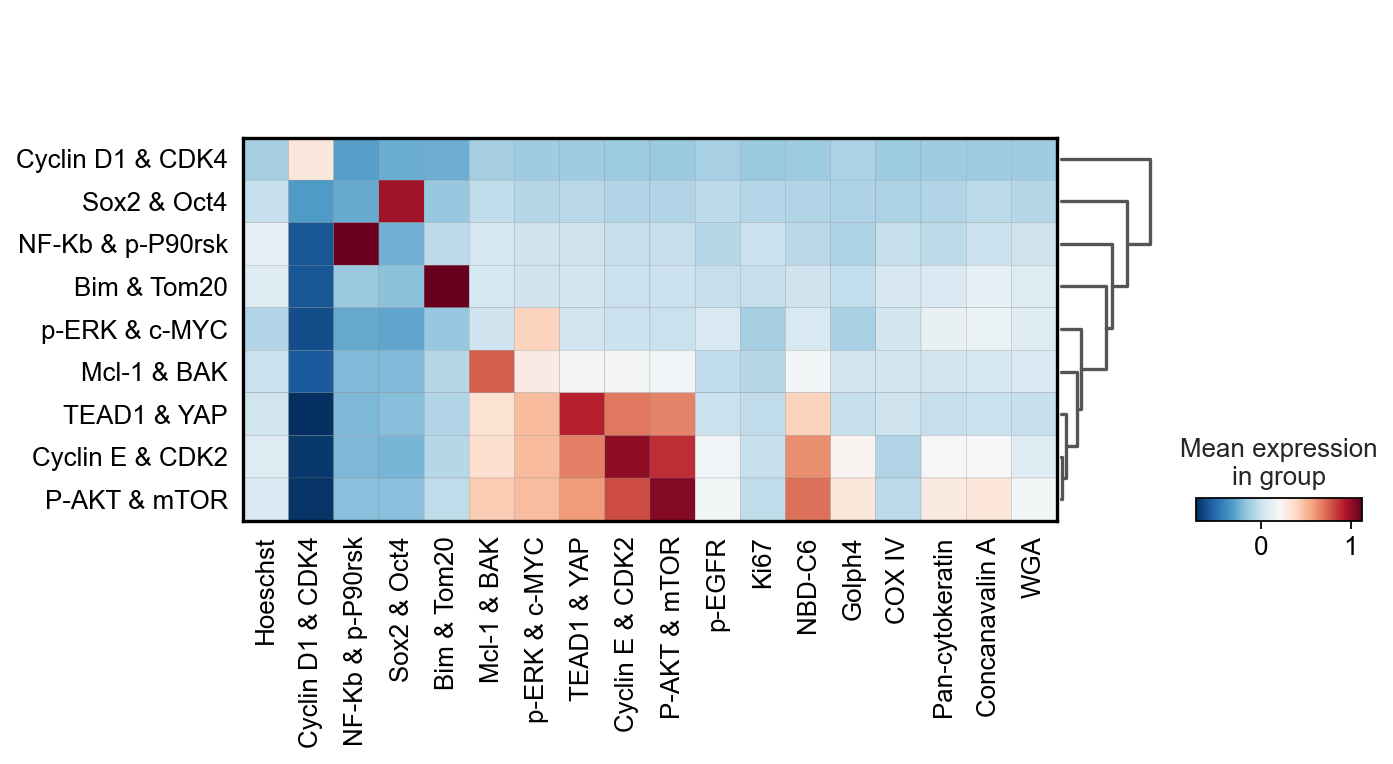

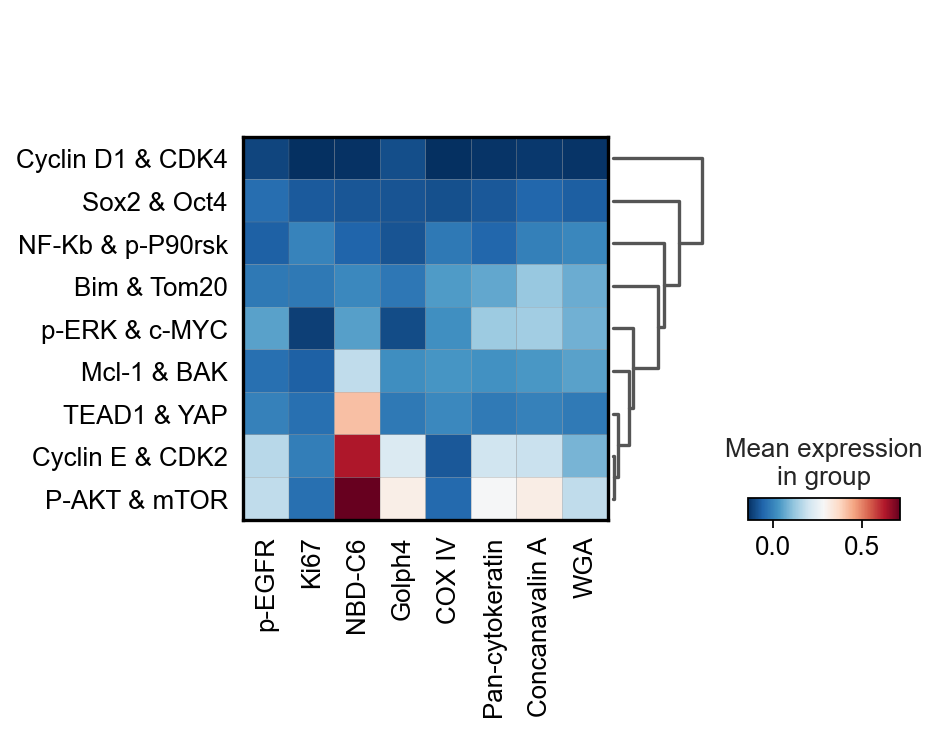

In [352]:
sc.pl.matrixplot(adata, adata.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata, adata.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


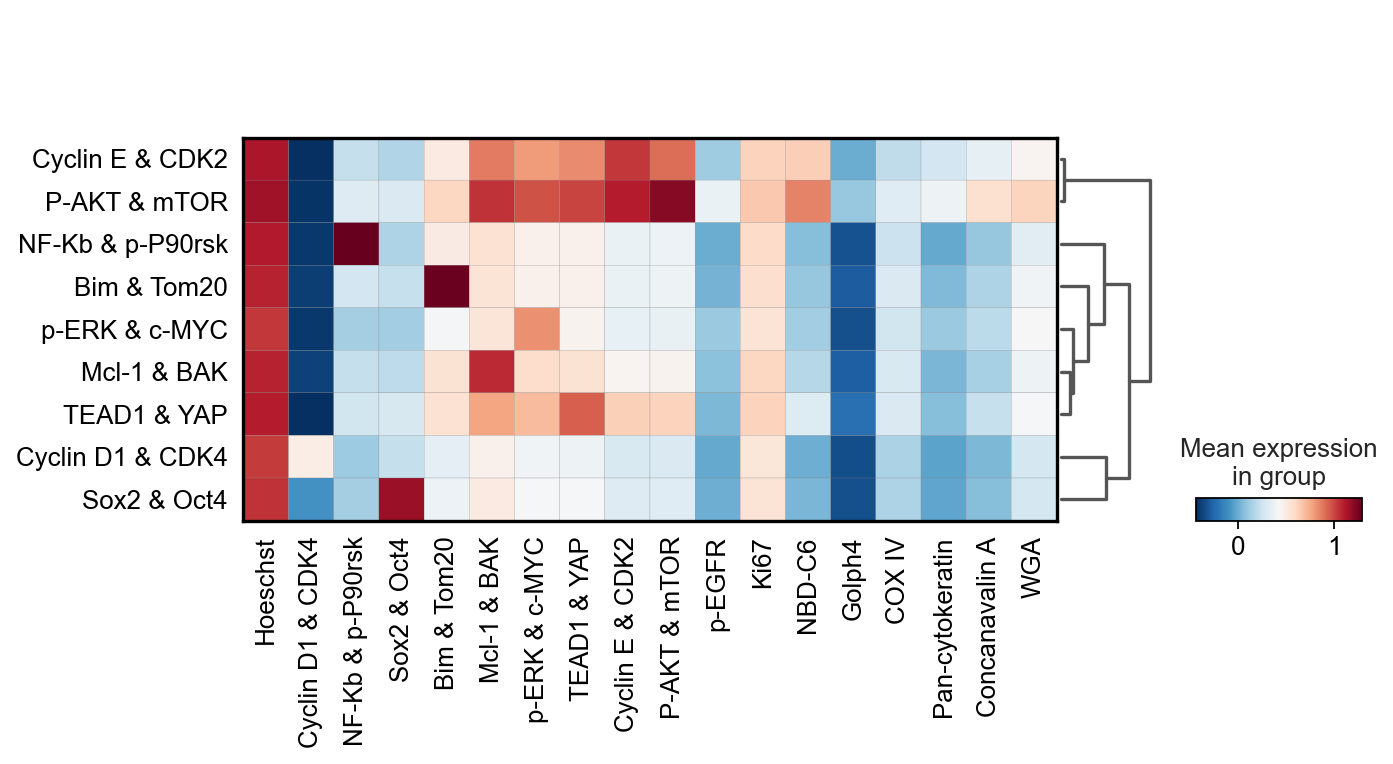

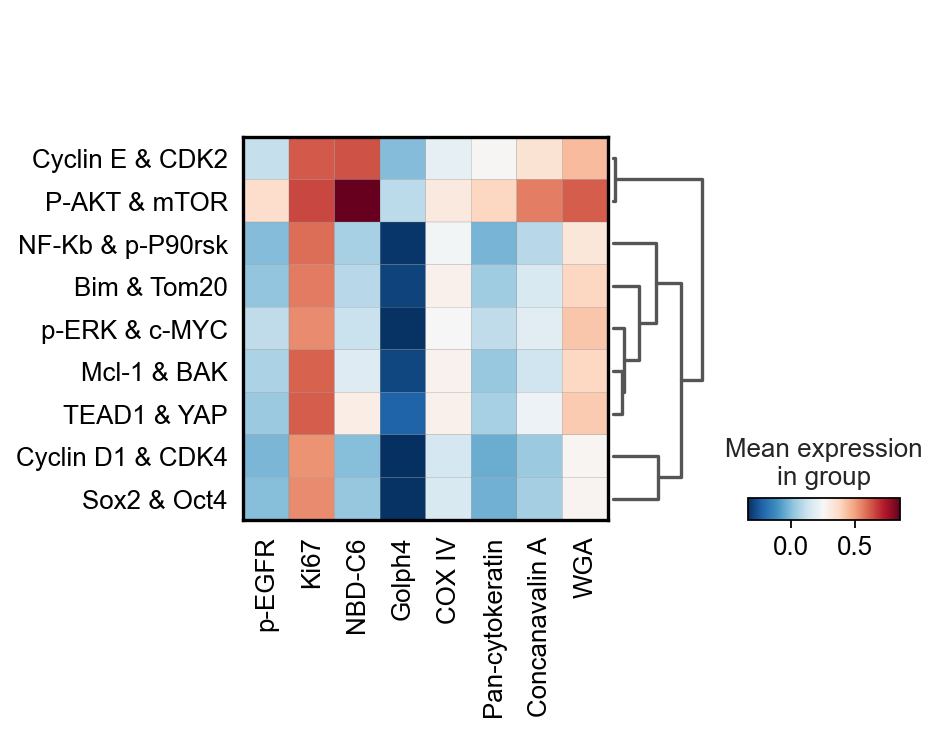

In [353]:
adata_subset = adata[adata.obs.Nuclei > 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


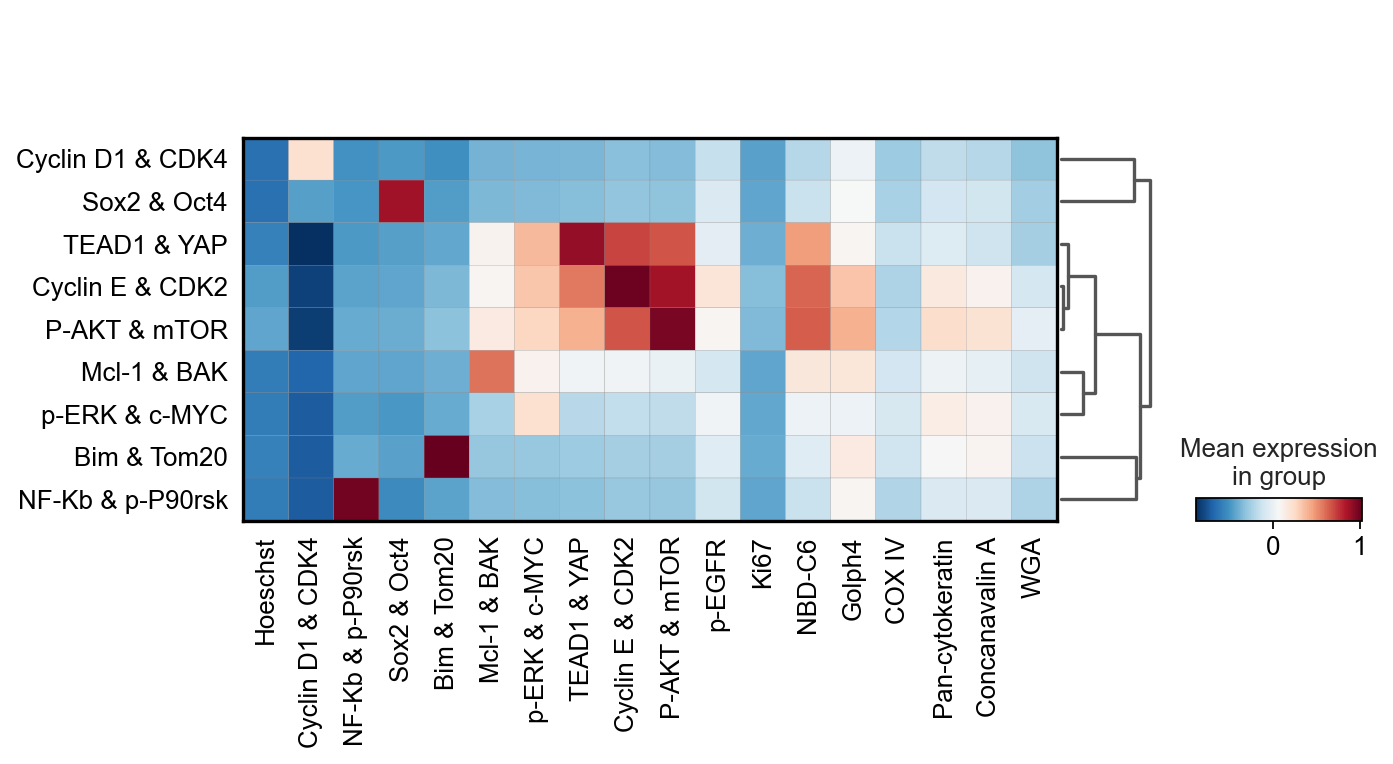

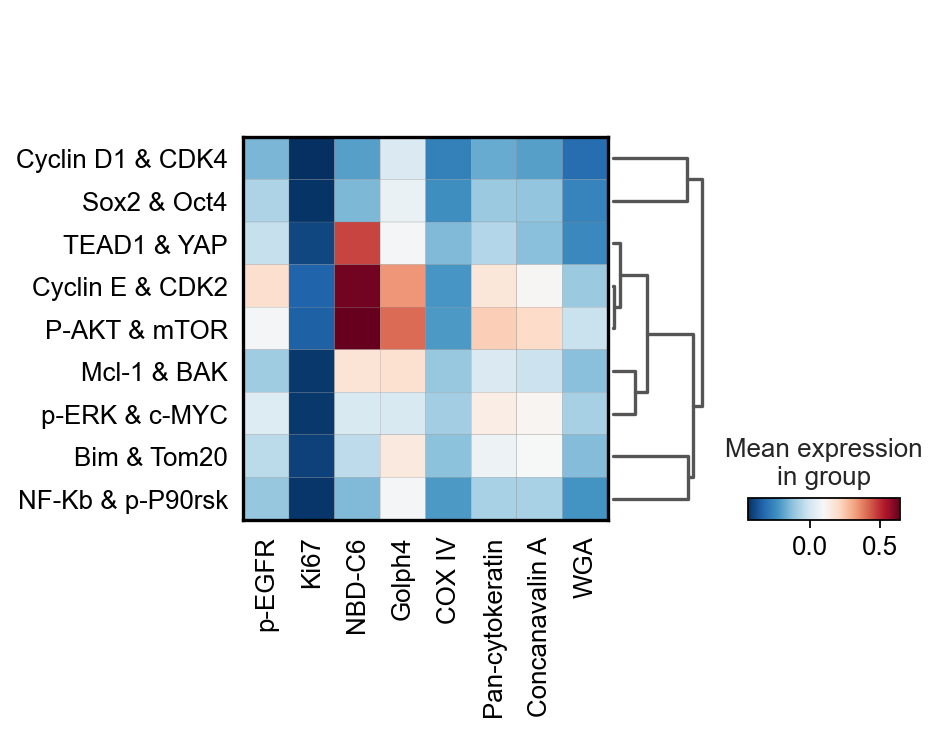

In [354]:
adata_subset = adata[adata.obs.Nuclei == 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

In [355]:
adata_high_count = adata[adata.obs.PPI.isin(['Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4', 'Bim & Tom20',
                                          'p-ERK & c-MYC'])].copy()
sc.pp.scale(adata_high_count)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


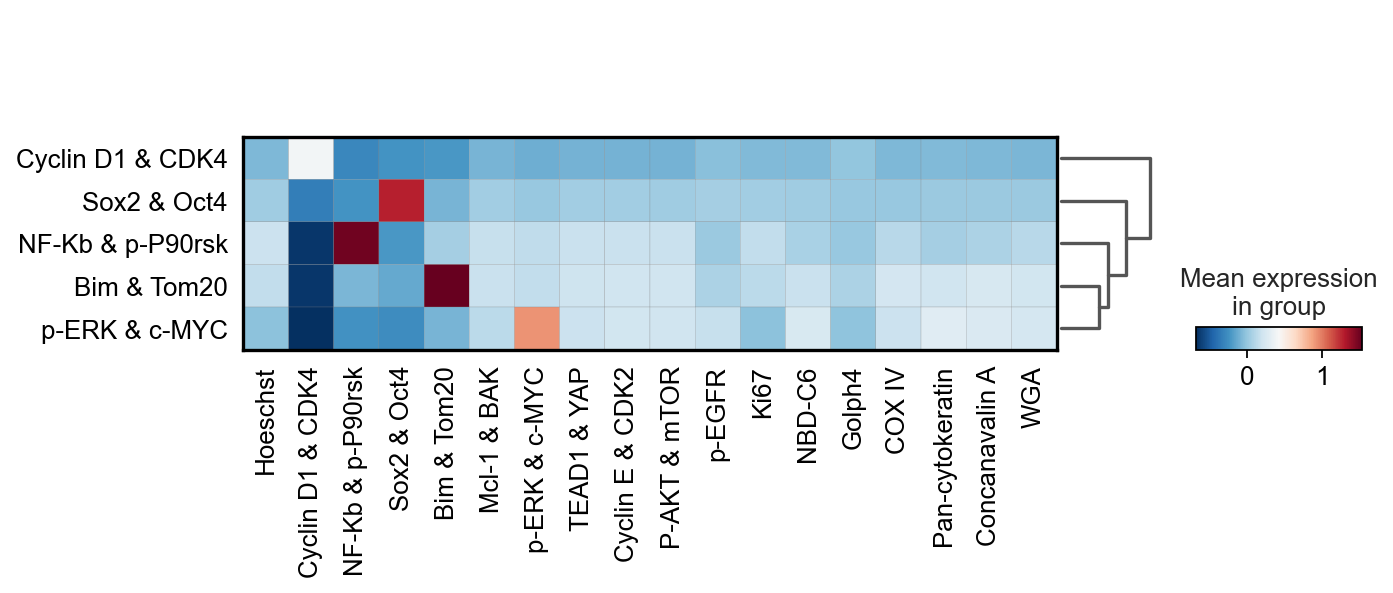

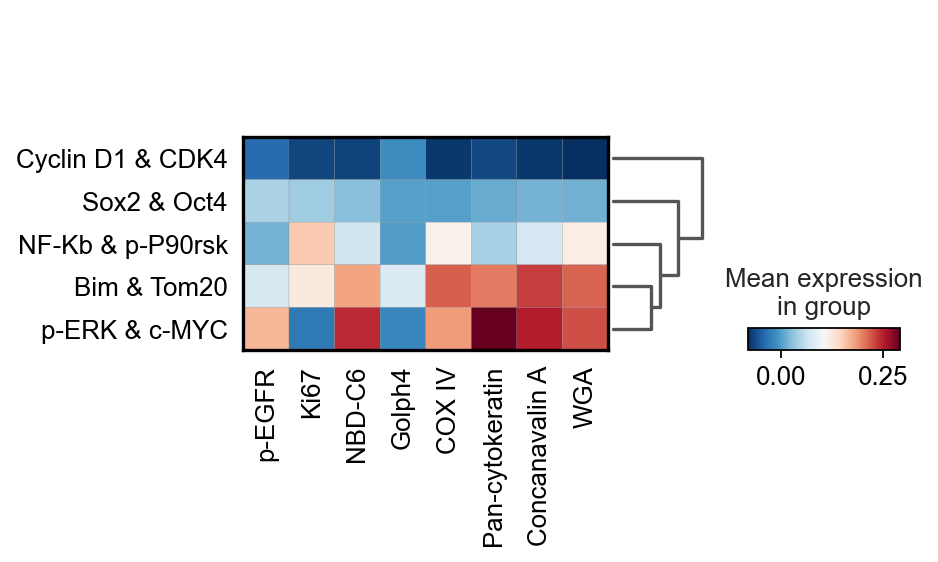

In [356]:
sc.tl.dendrogram(adata_high_count, groupby='PPI')

sc.pl.matrixplot(adata_high_count, adata_high_count.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_high_count, adata_high_count.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


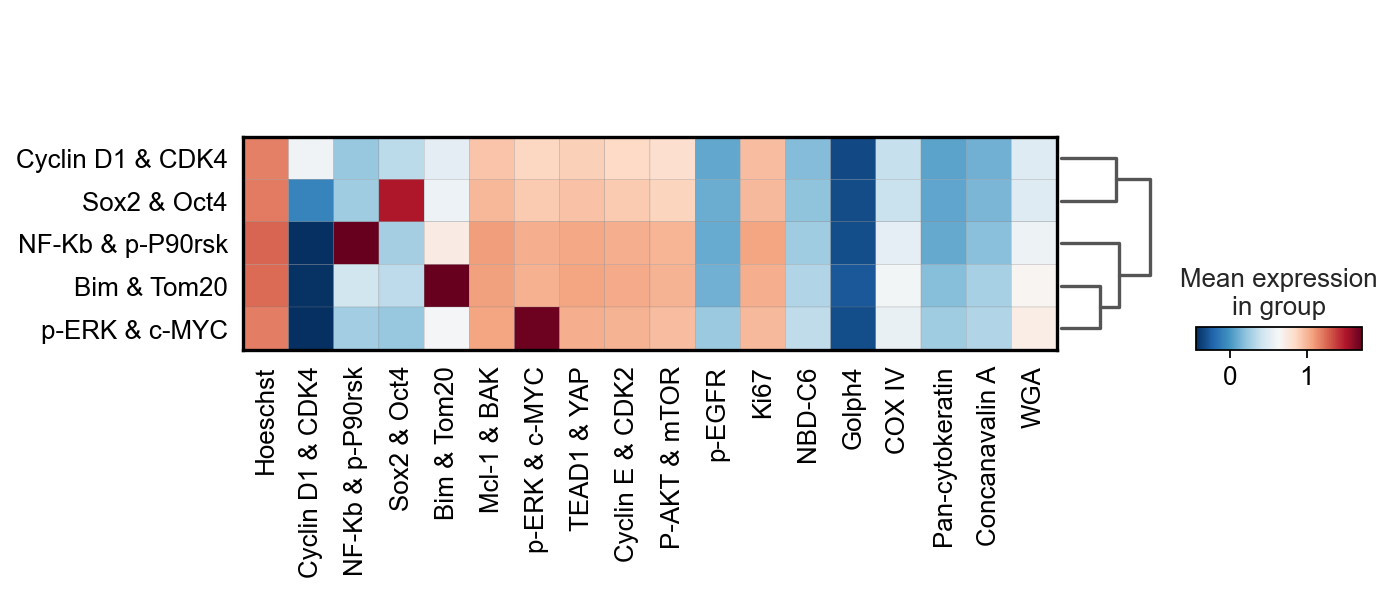

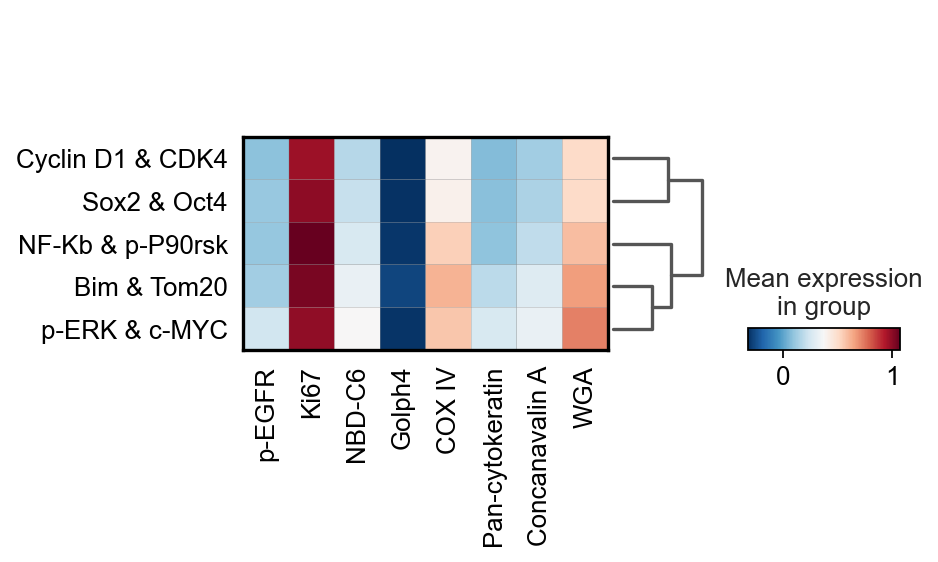

In [357]:
adata_subset = adata_high_count[adata_high_count.obs.Nuclei > 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


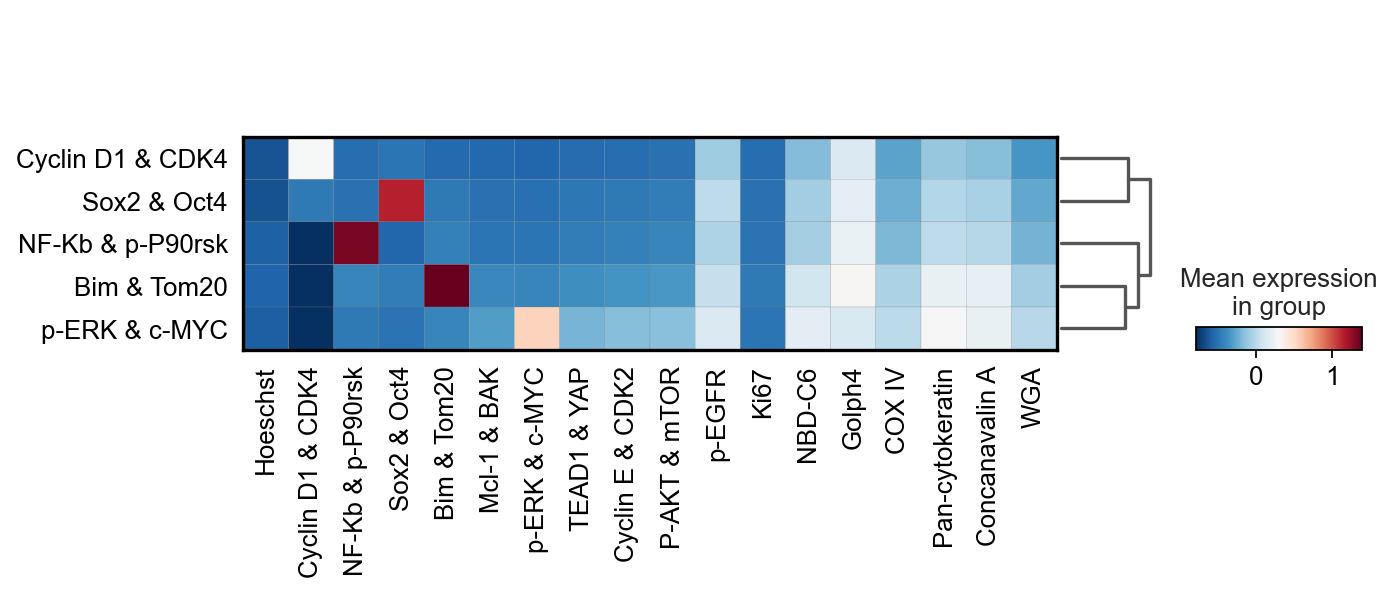

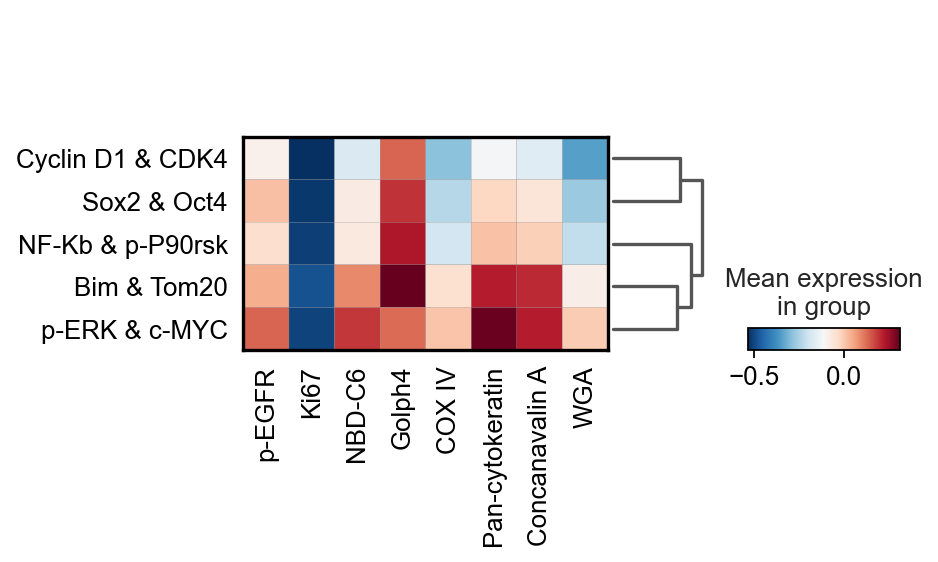

In [358]:
adata_subset = adata_high_count[adata_high_count.obs.Nuclei == 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

## PPI - Marker Correlation

In [359]:
import numpy as np
from scipy import stats
import matplotlib 

def create_HM(
    df_per_label, my_cmap, scale_name, cellSizePixels=25, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        dendrogram_ratio=(0.1, 0.1),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Marker")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.6
    ax.ax_cbar.set_position((1.8, pos.y0, .03, cbar_size))

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

def generate_correlation_map(x, y):
    corr = np.empty((len(x), len(y)))
    p_val = np.empty((len(x), len(y)))
    for n in range(x.shape[0]):
        for m in range(y.shape[0]):
            result = stats.pearsonr(x[n, :], y[m, :])
            corr[n, m] = result[0]
            p_val[n, m] = result[1]
    return corr, p_val

In [360]:
df_exp.columns

Index(['Original Index', 'Cyto', 'x', 'y', 'PPI', 'Nuclei', 'Condition', 'FOV',
       'Hoeschst', 'Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK2', 'P-AKT & mTOR', 'p-EGFR', 'Phalloidin', 'Ki67',
       'NBD-C6', 'Golph4', 'COX IV', 'Pan-cytokeratin', 'Concanavalin A',
       'WGA'],
      dtype='object')

In [361]:
label = 'PPI'
PPI_names = ['Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK2', 'P-AKT & mTOR']
# protein_marker_names = ['p-EGFR', 'Tom20', 'Pan-cytokeratin', 'Golph4', 'Ki67', 'NBD-C6', 'COX IV','Concanavalin A', 'WGA']
protein_marker_names = ['p-EGFR', 'Ki67',
       'NBD-C6', 'Golph4', 'COX IV', 'Pan-cytokeratin', 'Concanavalin A',
       'WGA']

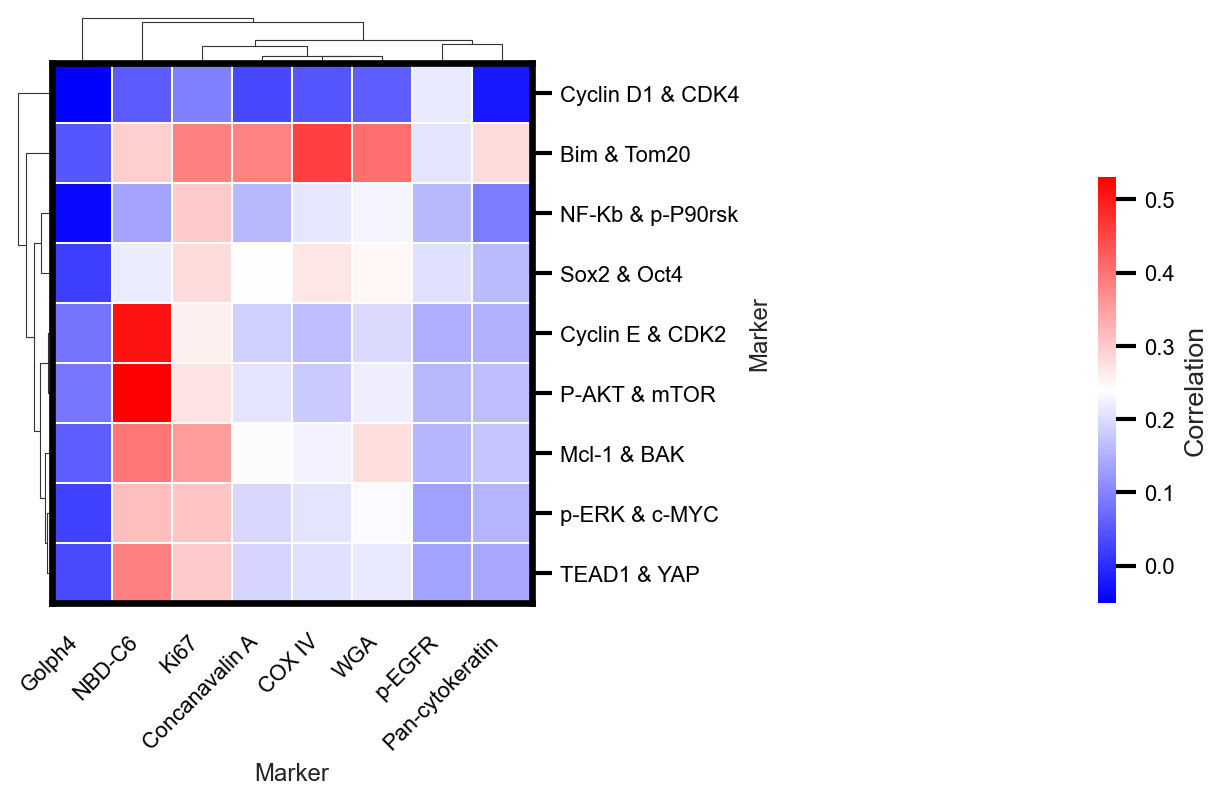

In [362]:
x = df_exp[PPI_names].values.T
y = df_exp[protein_marker_names].values.T

# Get correlation
corr, p_val = generate_correlation_map(x, y)

# Import into dataframe
df_corr = pd.DataFrame(corr, index=PPI_names, columns=protein_marker_names, )

with sns.plotting_context('talk', font_scale=0.6):
    create_HM(df_corr, 'bwr', 'Correlation', cellSizePixels=30)

('HCC827Ctrl',)
('HCC827Osim',)


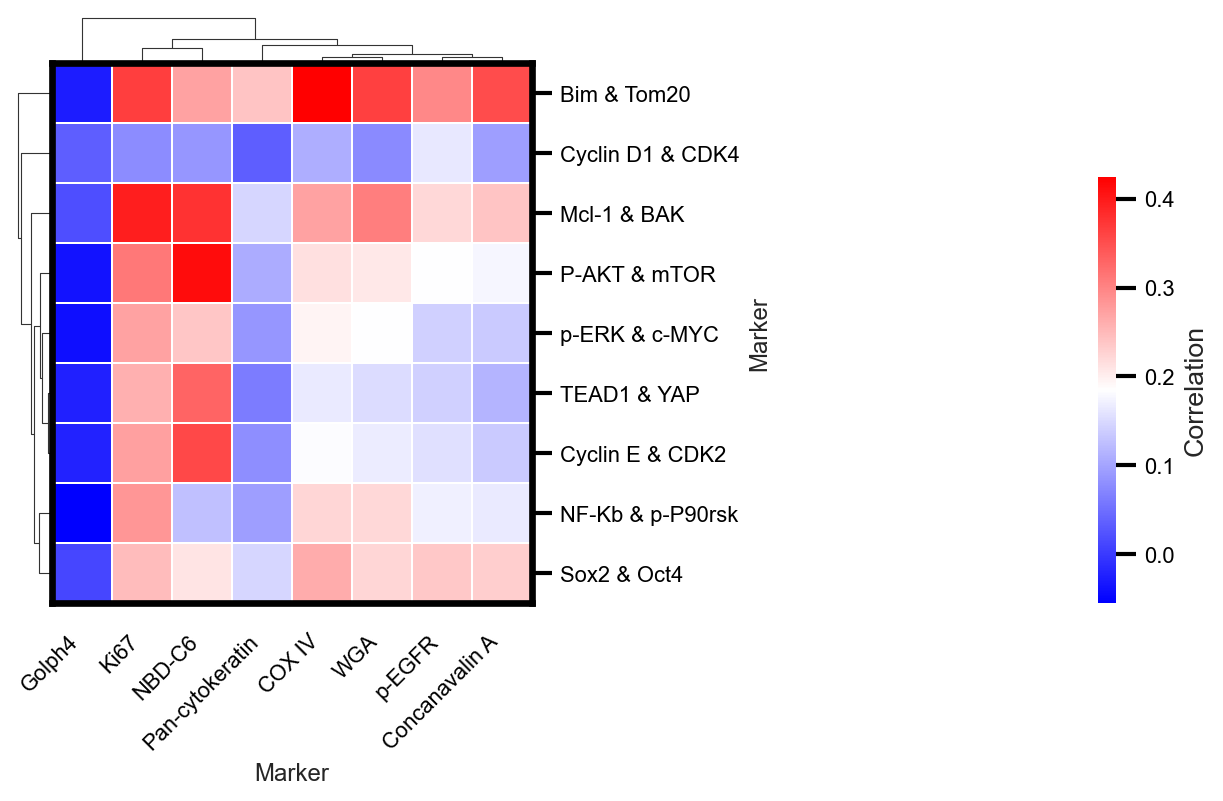

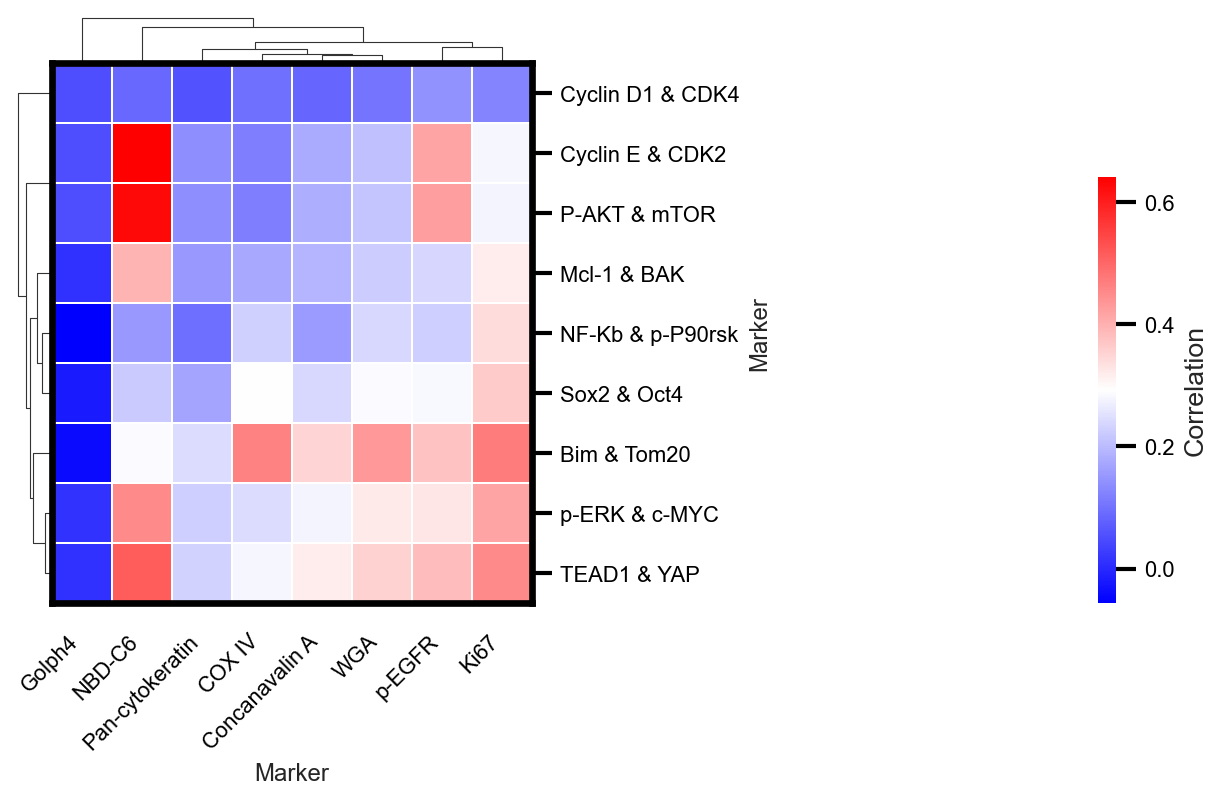

In [363]:
group = df_exp.groupby(['Condition'])
for name, df_group in group:
    print(name)
    x = df_group[PPI_names].values.T
    y = df_group[protein_marker_names].values.T
    
    # Get correlation
    corr, p_val = generate_correlation_map(x, y)
    
    # Import into dataframe
    df_corr = pd.DataFrame(corr, index=PPI_names, columns=protein_marker_names)
    
    # Create HM
    with sns.plotting_context('talk', font_scale=0.6):
        create_HM(df_corr, 'bwr', 'Correlation', cellSizePixels=30)
    

# Analysis on COX 4 positive regions

## Extracted cell intensity

In [364]:
from skimage import measure 

In [365]:
mask_filt_dir = data_dir / '9PPI Cell Culture' / 'Whole' / 'imgs' / 'masks_filtered'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [366]:
# exp_data_dir = data_dir / '9PPI Cell Culture' / 'Whole' / 'expression' 
# exp_data_dir.mkdir(exist_ok=True)

# for row in df_imgs.itertuples():
#     name = '_'.join(row[1:3])
#     imgs_path = row.Path
    
#     # Read masks
#     mask_cyto_path = masks_path[name]['cell']
#     mask_nuclei_path = masks_path[name]['nuclei']
#     df_path =  masks_path[name]['df']
    
#     mask_cyto = skimage.io.imread(mask_cyto_path)
    
#     # Read imgs
#     with h5py.File(imgs_path, "r") as f:
#         markers = f['imgs'].attrs['Marker']
#         index = np.where(markers == 'COX IV')[0][0]
#         img_pan = f['imgs'][index, :]
        
#     # Get mean expression per cell
#     props = measure.regionprops_table(mask_cyto, img_pan, properties=('label', 'mean_intensity'))
#     df_exp = pd.DataFrame(props)
#     df_exp.columns = ['Cell Id', 'Expression']
    
#     df_exp.to_csv(exp_data_dir / f'{name}.csv')
    

## Analysis on filtered region

In [367]:
def plot(plotting, figsize=(7,4)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [368]:
sns.set_style('white')

In [369]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [370]:
exp_data_dir = data_dir / '9PPI Cell Culture' / 'Whole' / 'expression' 

dfs = []
for path in os.listdir(exp_data_dir):
    if 'csv' in path:
        df = pd.read_csv(exp_data_dir / path)
        df['Expression'] = scaler.fit_transform(df[['Expression']])
        name_list = os.path.splitext(path)[0].split('_')
        df['Condition'] = name_list[0]
        df['FOV'] = name_list[1]
        dfs.append(df)

df_exp_cell = pd.concat(dfs)


In [371]:
df_merged = df_all.merge(df_exp_cell, how='left', left_on=['Condition', 'FOV', 'Id'], right_on=['Condition', 'FOV', 'Cell Id'])

In [372]:
df_merged =  df_merged[df_merged['Expression'] > 0.1]
df_merged

Condition  FOV            PPI   Id  Count_cell  Count_nuclei  \
0     HCC827Ctrl  FW1    Bim & Tom20   15          20             5   
1     HCC827Ctrl  FW1    Bim & Tom20   16           7             1   
2     HCC827Ctrl  FW1    Bim & Tom20   17          23            16   
3     HCC827Ctrl  FW1    Bim & Tom20   18          57            40   
4     HCC827Ctrl  FW1    Bim & Tom20   19          26            18   
...          ...  ...            ...  ...         ...           ...   
8153  HCC827Osim  FW2  p-ERK & c-MYC  340           3             1   
8154  HCC827Osim  FW2  p-ERK & c-MYC  341           6             2   
8155  HCC827Osim  FW2  p-ERK & c-MYC  343           6             3   
8156  HCC827Osim  FW2  p-ERK & c-MYC  344           8             2   
8157  HCC827Osim  FW2  p-ERK & c-MYC  345           6             3   

      Count_cyto  Unnamed: 0  Cell Id  Expression  
0             15           5       15    0.243062  
1              6           6       16    0.514000  
2              7           7       17    0.316622  
3             17           8       18    0.159401  
4              8           9       19    0.133143  
...          ...         ...      ...         ...  
8153           2         317      340    0.376882  
8154           4         318      341    0.223711  
8155           3         319      343    0.170166  
8156           6         320      344    0.274312  
8157           3         321      345    0.118240  

[3522 rows x 10 columns]

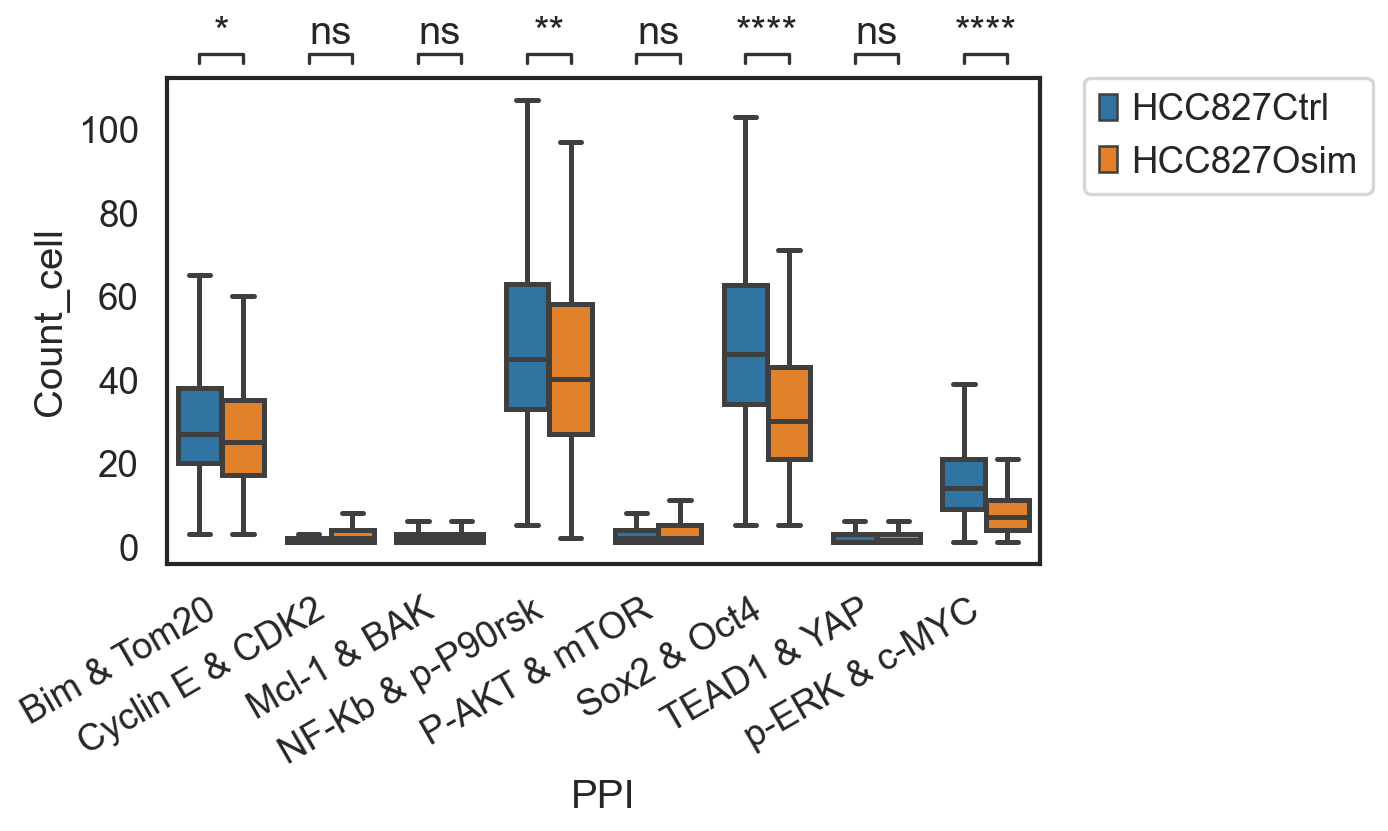

In [373]:
# Boxplot per cell
plotting = {
    "data": df_merged,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

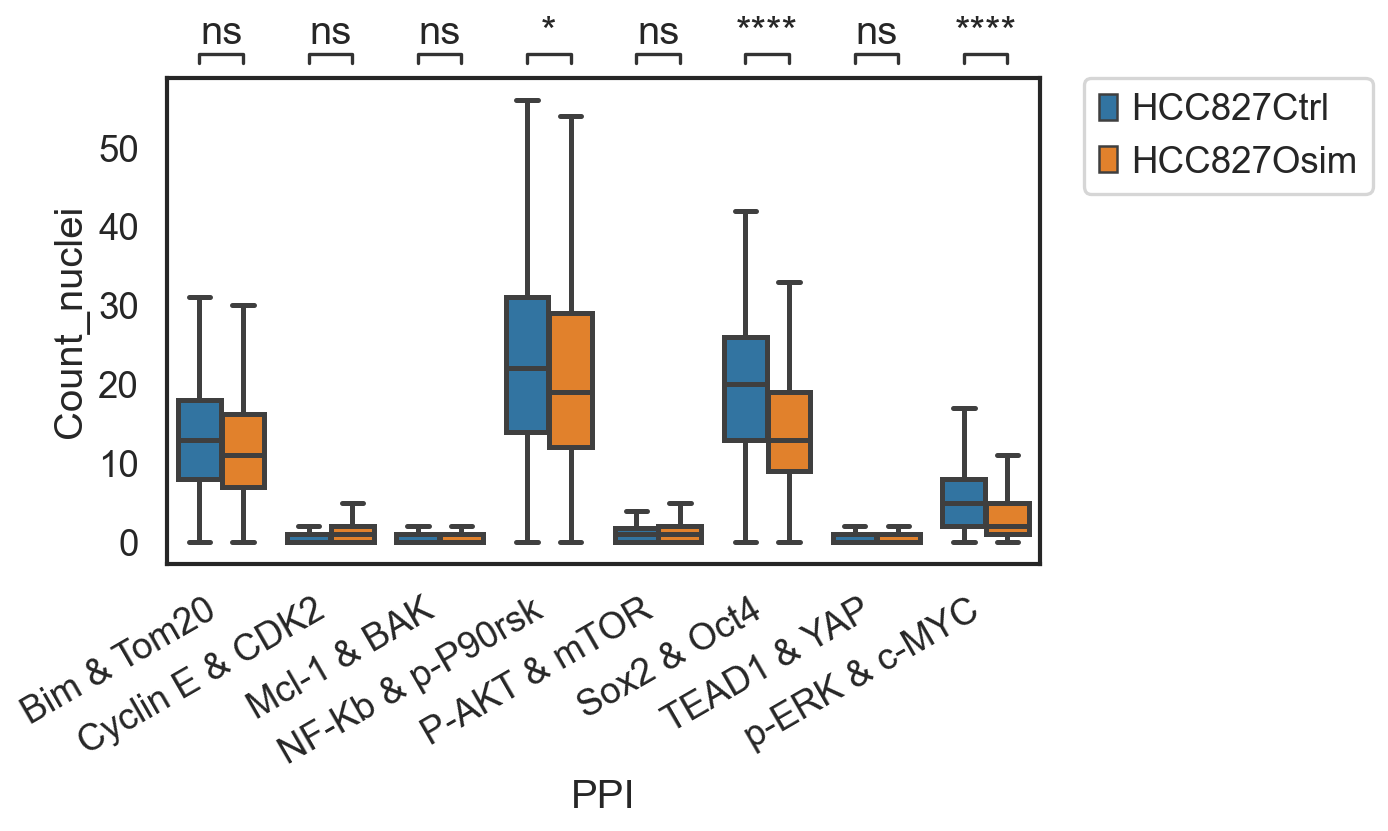

In [374]:
# Boxplot per cell
plotting = {
    "data": df_merged,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

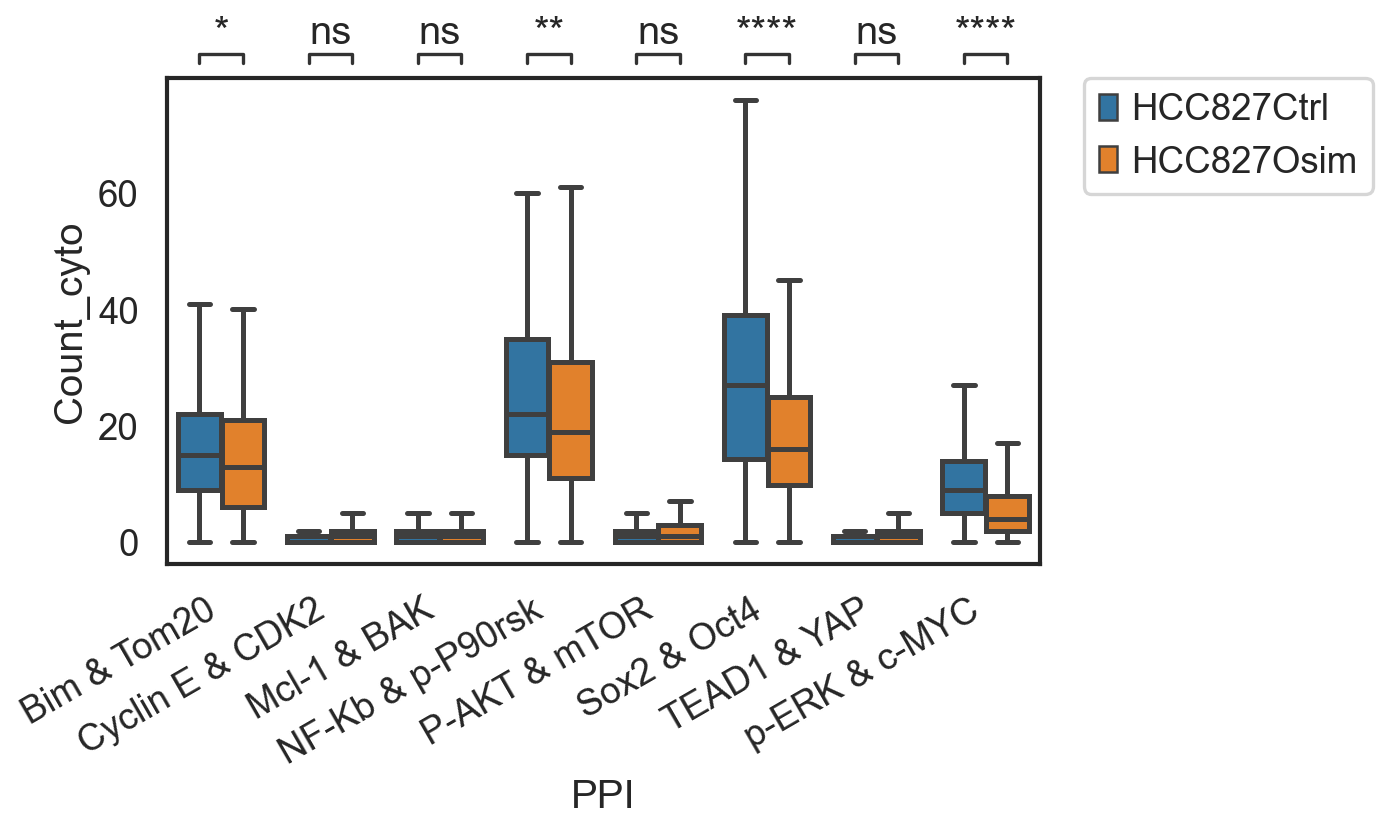

In [375]:
# Boxplot per cell
plotting = {
    "data": df_merged,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E & CDK2_Count_nuclei vs. Cyclin E & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:5.830e-02 U_stat=8.160e+03
Bim & Tom20_Count_nuclei vs. Bim & Tom20_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.122e-03 U_stat=3.321e+04
Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.704e-02 U_stat=1.933e+04
NF-Kb & p-P90rsk_Count_nuclei vs. NF-Kb & p-P90rsk_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.098e-01 U_stat=3.640e+04
P-AKT & mTOR_Count_nuclei vs. P-AKT & mTOR_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:6.023e-01 U_stat=4.604e+03
Sox2 & Oct4_Count_nuclei vs. Sox2 & Oct4_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.009e-07 U_stat=2.946e+04
TEAD1 & YAP_Count_nuclei vs. TEAD1 & YAP_Count_cyto: Ma

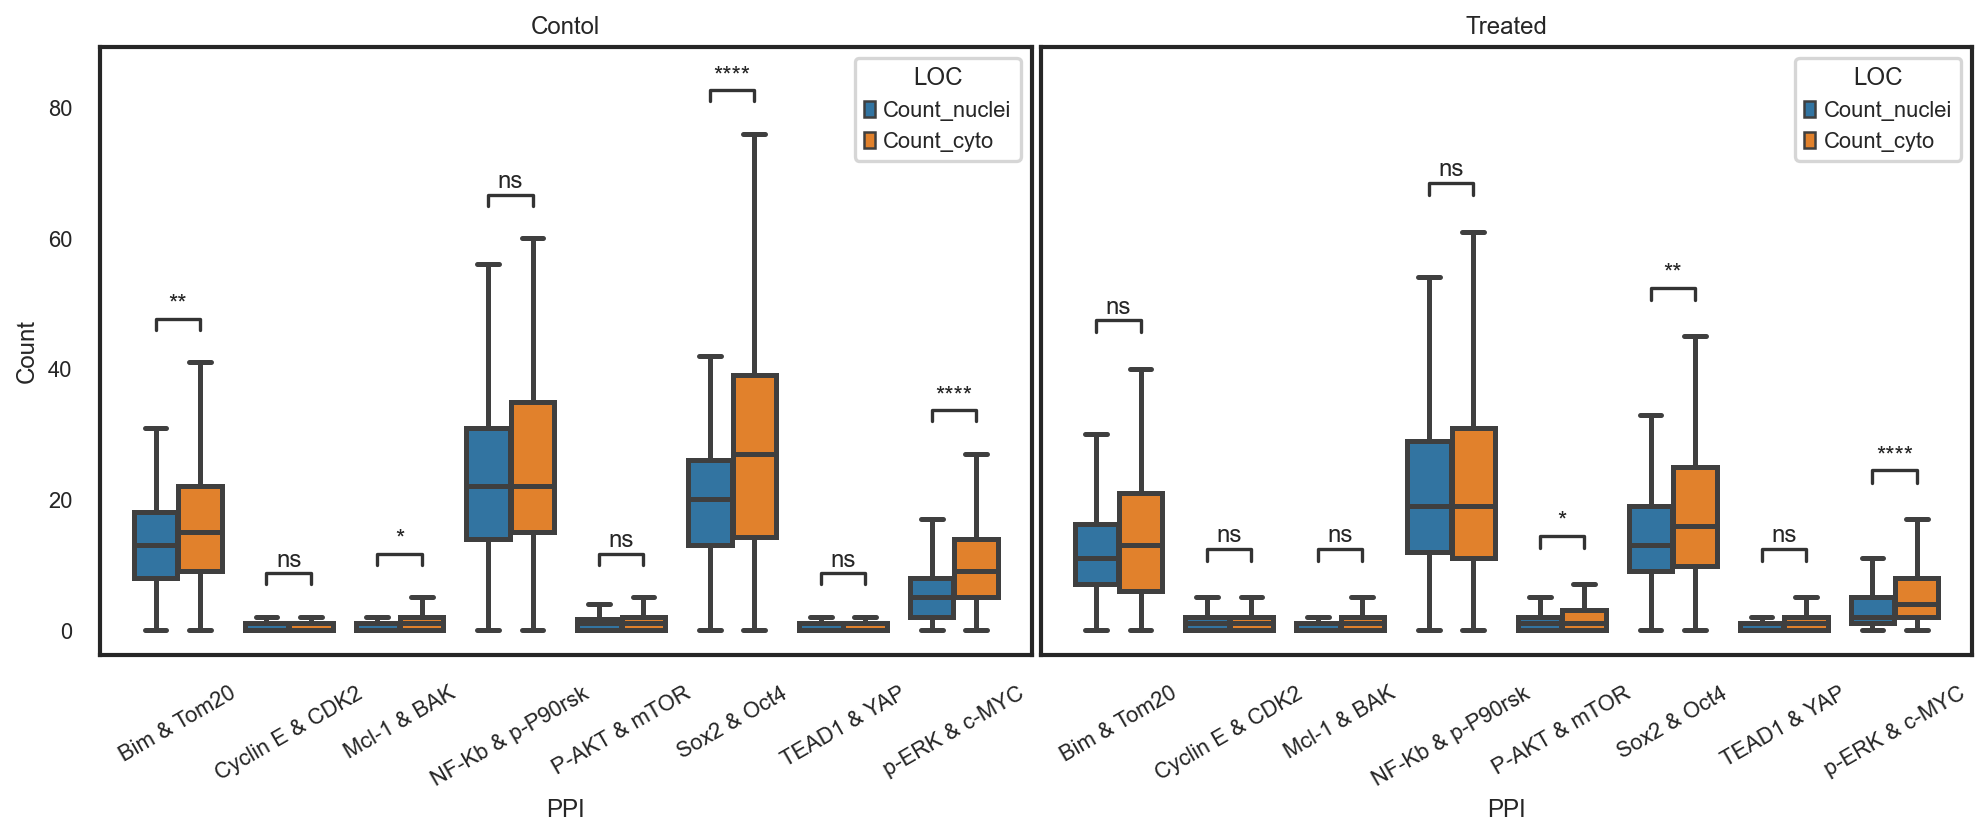

In [376]:
# Boxplot per loc
df_melt = df_merged.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


df_melt['Count'] = df_melt['Count'].clip(0, upper=None)

with sns.plotting_context('talk', font_scale=0.6):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == 'HCC827Ctrl']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == 'HCC827Osim']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)

In [377]:
df_subset = df_merged[~df_merged['PPI'].isin(['Cyclin D1 & CDK4'])]

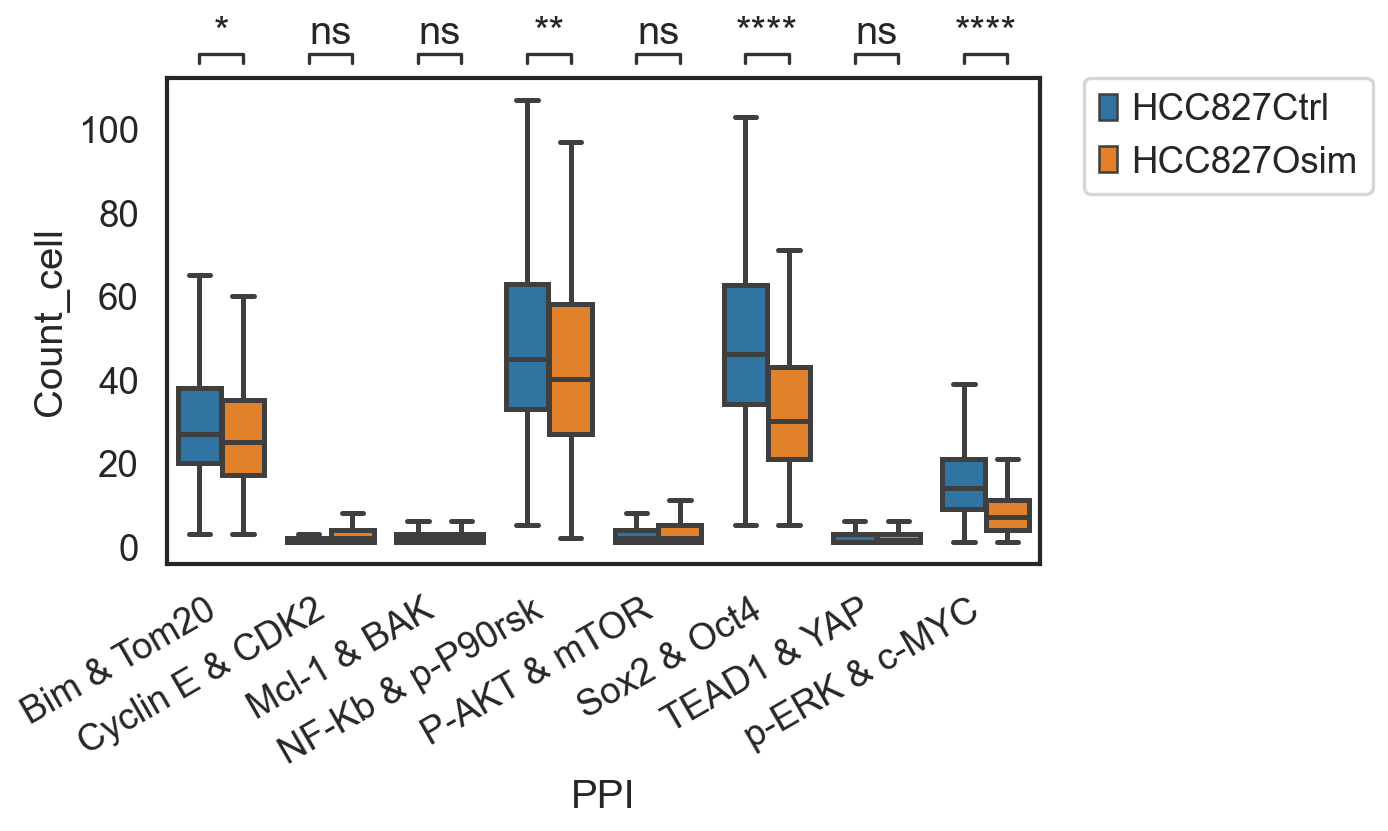

In [378]:
# Boxplot per cell
plotting = {
    "data": df_subset ,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

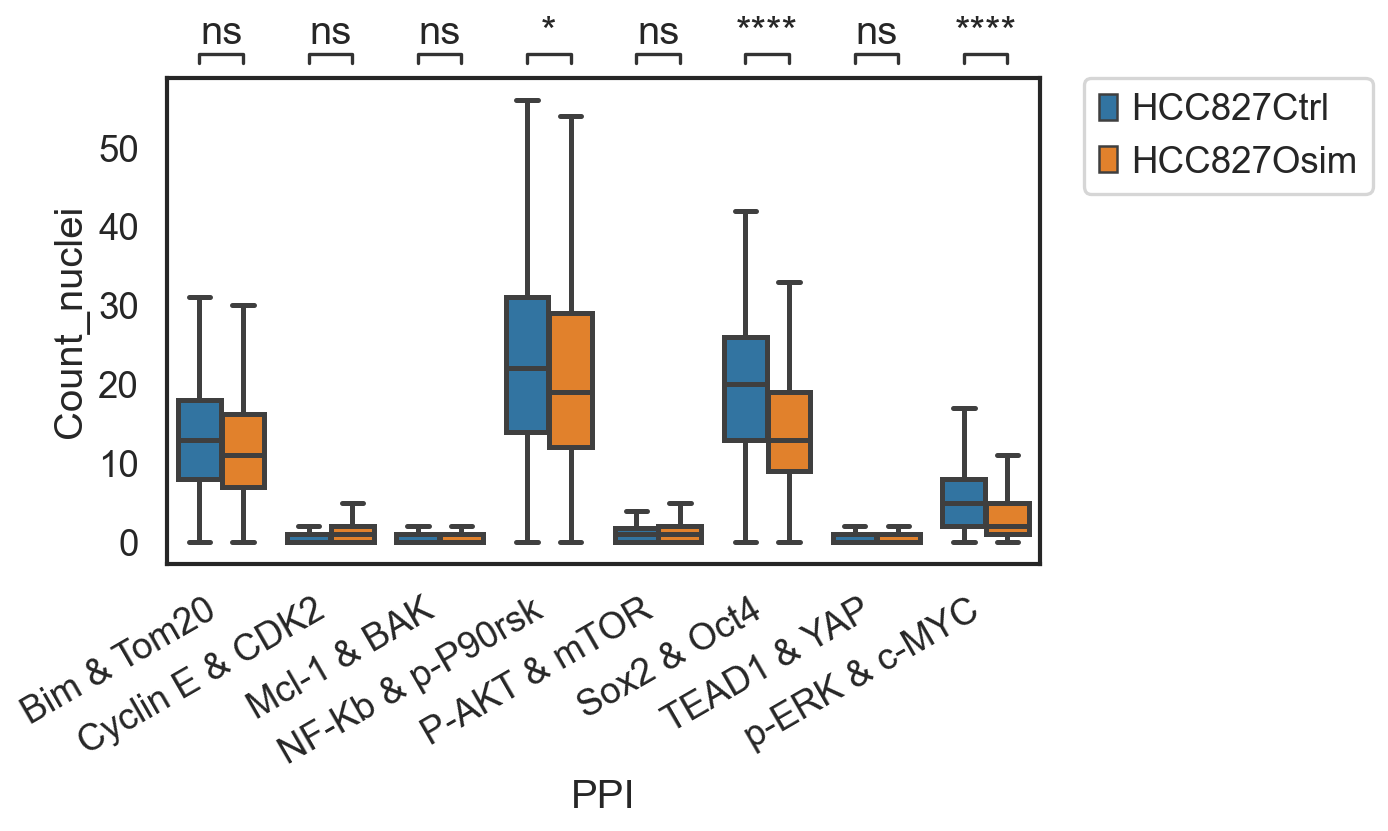

In [379]:
# Boxplot per cell
plotting = {
    "data": df_subset,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

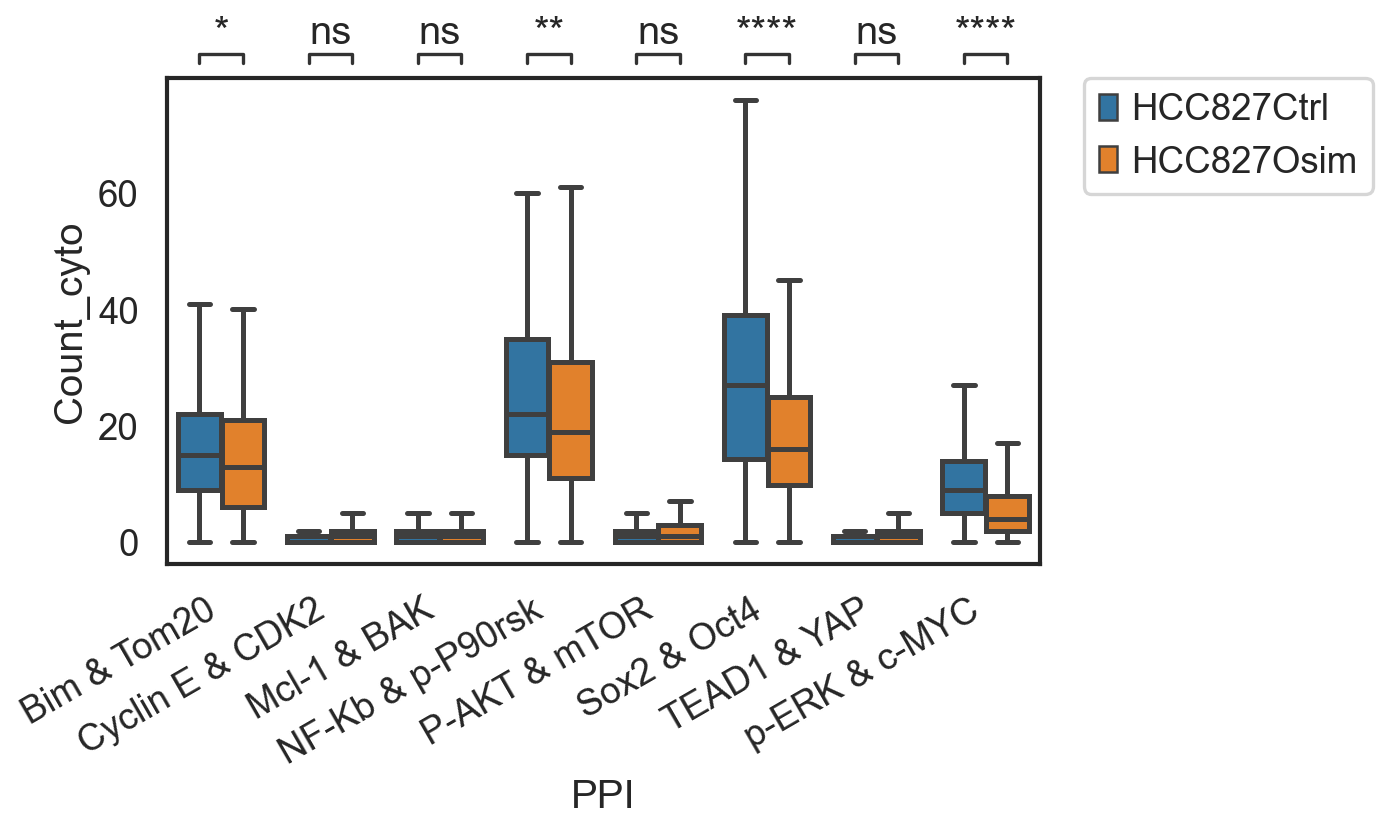

In [380]:
# Boxplot per cell
plotting = {
    "data": df_subset,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E & CDK2_Count_nuclei vs. Cyclin E & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:5.830e-02 U_stat=8.160e+03
Bim & Tom20_Count_nuclei vs. Bim & Tom20_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.122e-03 U_stat=3.321e+04
Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.704e-02 U_stat=1.933e+04
NF-Kb & p-P90rsk_Count_nuclei vs. NF-Kb & p-P90rsk_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.098e-01 U_stat=3.640e+04
P-AKT & mTOR_Count_nuclei vs. P-AKT & mTOR_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:6.023e-01 U_stat=4.604e+03
Sox2 & Oct4_Count_nuclei vs. Sox2 & Oct4_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.009e-07 U_stat=2.946e+04
TEAD1 & YAP_Count_nuclei vs. TEAD1 & YAP_Count_cyto: Ma

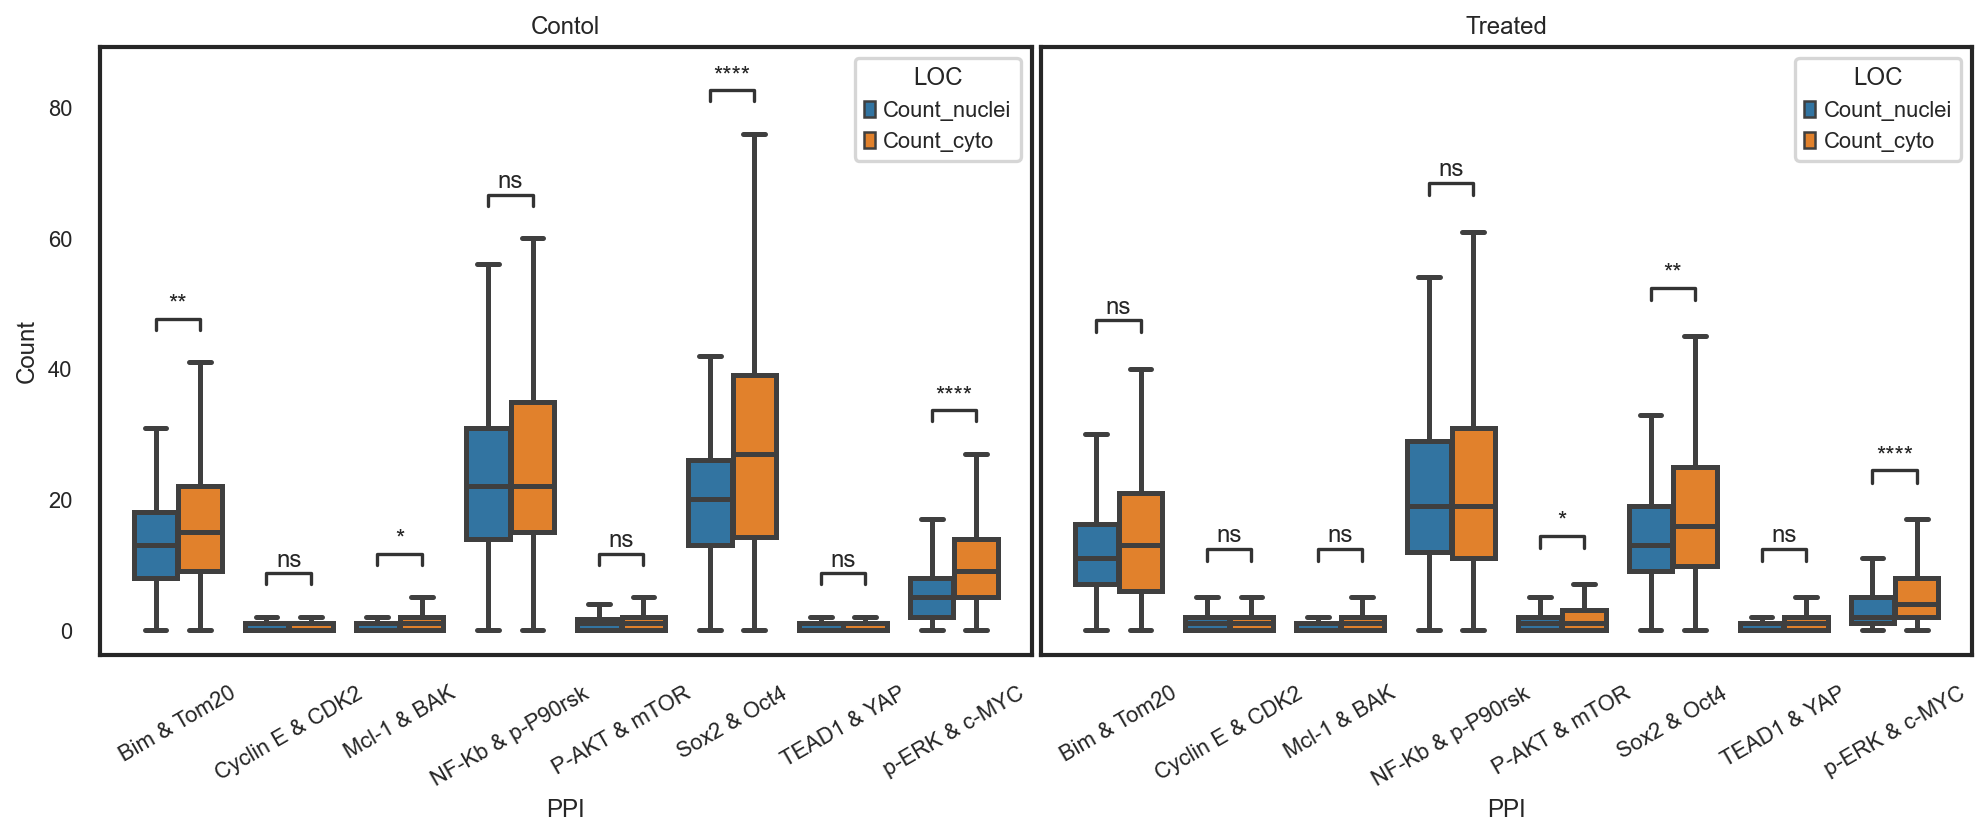

In [381]:
# Boxplot per loc
df_melt = df_subset.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


df_melt['Count'] = df_melt['Count'].clip(0, upper=None)

with sns.plotting_context('talk', font_scale=0.6):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == 'HCC827Ctrl']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == 'HCC827Osim']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)

## PPI co-expression boxplot

In [382]:
def plot(plotting, ):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=(15,3))
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.barplot(**plotting, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        
def plot(plotting, ax):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]


    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
    result = annot.apply_test().annotate()
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)


In [383]:
# Read PPI data
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI' / 'expression'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path, index_col=0)
        dfs.append(df)

df_exp = pd.concat(dfs)
df_exp = df_exp.rename(columns = {'Cyclin D1 & CDK2': 'Cyclin D1 & CDK4', 'Cyclin E & CDK4':'Cyclin E & CDK2'})
df_exp['PPI'] = df_exp['PPI'].apply(lambda x: {'Cyclin D1 & CDK2': 'Cyclin D1 & CDK4', 'Cyclin E & CDK4':'Cyclin E & CDK2'}.get(x,x))

In [384]:
df_exp = df_exp.merge(df_exp_cell, how='left', left_on=['Condition', 'FOV', 'Cyto'], right_on=['Condition', 'FOV', 'Cell Id'])
df_exp = df_exp[df_exp['Expression'] > 0.1]
df_exp = df_exp.iloc[:,:-3]

In [385]:
df_exp.columns

Index(['Original Index', 'Cyto', 'x', 'y', 'PPI', 'Nuclei', 'Condition', 'FOV',
       'Hoeschst', 'Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK2', 'P-AKT & mTOR', 'p-EGFR', 'Phalloidin', 'Ki67',
       'Cyclin D1 & CDK2 - re', 'NF-Kb & p-P90rsk - re', 'NBD-C6', 'Golph4',
       'COX IV', 'Pan-cytokeratin', 'Concanavalin A', 'WGA'],
      dtype='object')

In [386]:
df_exp = df_exp[~df_exp['PPI'].isin(['Cyclin D1 & CDK2 - re',  'NF-Kb & p-P90rsk - re'])]
df_exp.drop(['Cyclin D1 & CDK2 - re',  'NF-Kb & p-P90rsk - re'], axis=1, inplace=True)

In [387]:
# Check for general trend y converting to adata and groupby by Condition
df_obs = df_exp.iloc[:, :8]
df_marker_exp = df_exp.iloc[:, 8:]
df_norm = (df_marker_exp-df_marker_exp.min())/(df_marker_exp.max()-df_marker_exp.min())
# df_norm = (df_marker_exp - df_marker_exp.mean())/df_marker_exp.std()
# df_norm = (df_marker_exp-df_marker_exp.quantile(0.05))/(df_marker_exp.quantile(0.95)-df_marker_exp.quantile(0.05))
df_norm = df_norm.clip(lower=0, upper=1)
df_exp.iloc[:, 8:] = df_norm

In [388]:
# df_melt = df_exp.melt(id_vars = df_obs.columns, value_vars = df_norm.columns, 
#                       var_name = 'Marker', value_name='Intensity')
# rows = len(df_melt.PPI.unique()) 

# with sns.axes_style("white"):        
#     with sns.plotting_context('talk', font_scale=1):
#         fig, axs = plt.subplots(rows,1,figsize=(15,3*rows), sharex=True)
#         for i, ppi in enumerate(df_melt.PPI.unique()):
#             print(ppi)
#             ax = axs[i]
#             plotting = {
#                 "data": df_melt[(df_melt.PPI == ppi) & (df_melt.Marker != 'Hoeschst')],
#                 "x": "Marker",
#                 "y": "Intensity",
#                 "hue": "Condition"
#             }

#             plot(plotting, ax=ax)
#             ax.set_xlabel('')
#             ax.set_ylabel(ppi)
#         plt.xticks(rotation=30, ha='right')


In [389]:
# df_melt = df_exp.melt(id_vars = df_obs.columns, value_vars = df_norm.columns, 
#                       var_name = 'Marker', value_name='Intensity')
# df_nuclei = df_melt[df_melt.Nuclei > 0]

# rows = len(df_melt.PPI.unique()) 
# with sns.axes_style("white"):        
#     with sns.plotting_context('talk', font_scale=1):
#         fig, axs = plt.subplots(rows,1,figsize=(15,3*rows), sharex=True)
#         for i, ppi in enumerate(df_melt.PPI.unique()):
#             print(ppi)
#             ax = axs[i]
#             plotting = {
#                 "data": df_nuclei[(df_nuclei.PPI == ppi) & (df_melt.Marker != 'Hoeschst')],
#                 "x": "Marker",
#                 "y": "Intensity",
#                 "hue": "Condition"
#             }
            
#             plot(plotting, ax=ax)
#             ax.set_xlabel('')
#             ax.set_ylabel(ppi)
#         plt.xticks(rotation=30, ha='right')


In [390]:
# df_melt = df_exp.melt(id_vars = df_obs.columns, value_vars = df_norm.columns, 
#                       var_name = 'Marker', value_name='Intensity')
# df_cyto = df_melt[df_melt.Nuclei ==  0]

# rows = len(df_melt.PPI.unique()) 
# with sns.axes_style("white"):        
#     with sns.plotting_context('talk', font_scale=1):
#         fig, axs = plt.subplots(rows,1,figsize=(15,3*rows), sharex=True)
#         for i, ppi in enumerate(df_melt.PPI.unique()):
#             print(ppi)
#             ax = axs[i]
#             plotting = {
#                 "data": df_cyto[(df_cyto.PPI == ppi) & (df_melt.Marker != 'Hoeschst')],
#                 "x": "Marker",
#                 "y": "Intensity",
#                 "hue": "Condition"
#             }

#             plot(plotting, ax=ax)
#             ax.set_xlabel('')
#             ax.set_ylabel(ppi)
#         plt.xticks(rotation=30, ha='right')


## PPI-Marker co-expression

In [391]:
df_marker_exp = df_marker_exp.drop(['Phalloidin'], axis=1)

adata = ad.AnnData(df_marker_exp.values, dtype=df_norm.values.dtype)
adata.var_names = df_marker_exp.columns.tolist()
adata.obs = df_obs
adata.obs['PPI'] = adata.obs['PPI'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=1.5)
sc.tl.dendrogram(adata, groupby='PPI')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [8, 10, 19, 26, 27]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


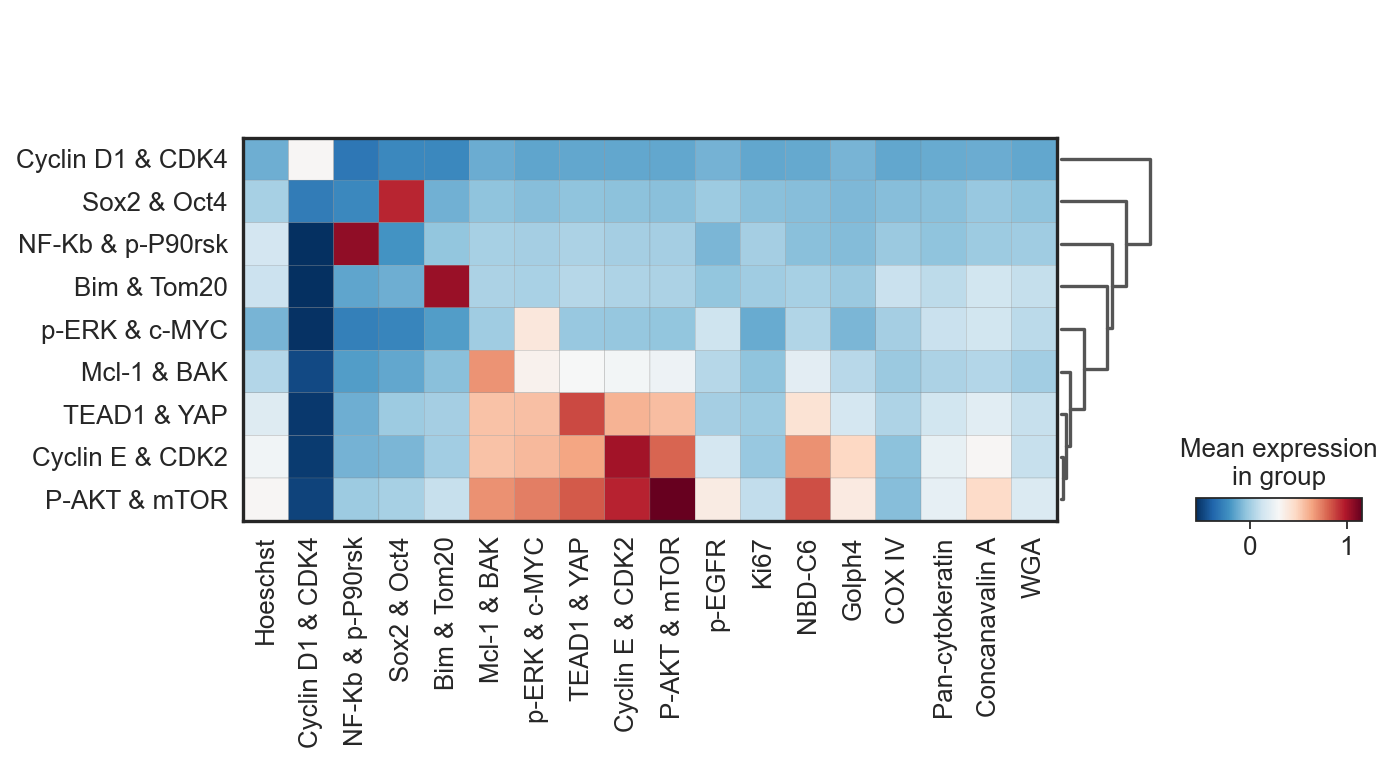

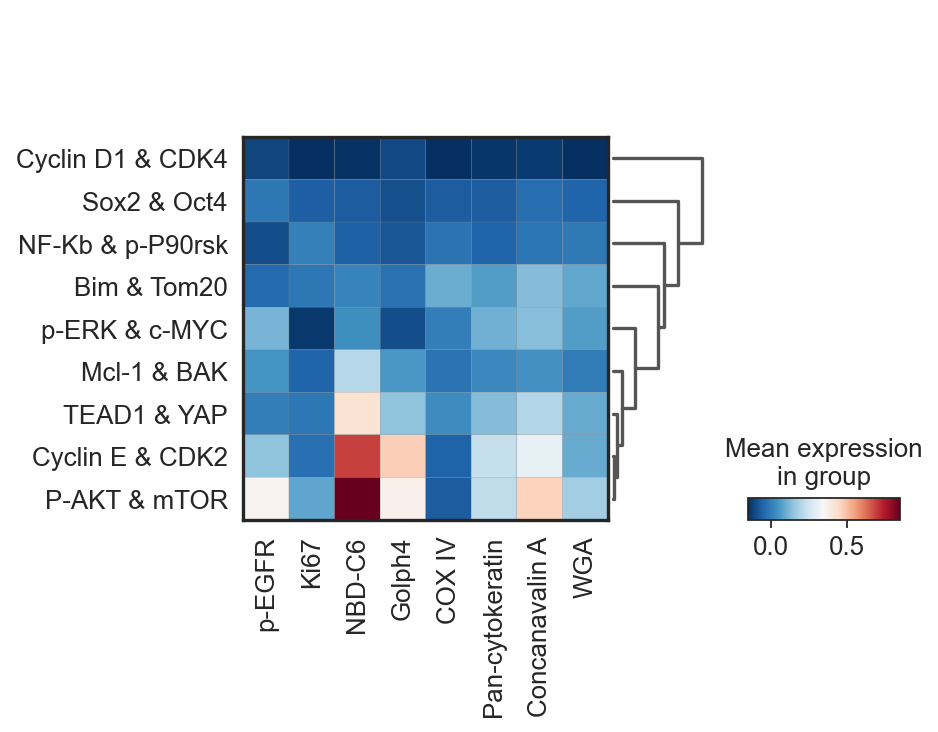

In [392]:
sc.pl.matrixplot(adata, adata.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata, adata.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


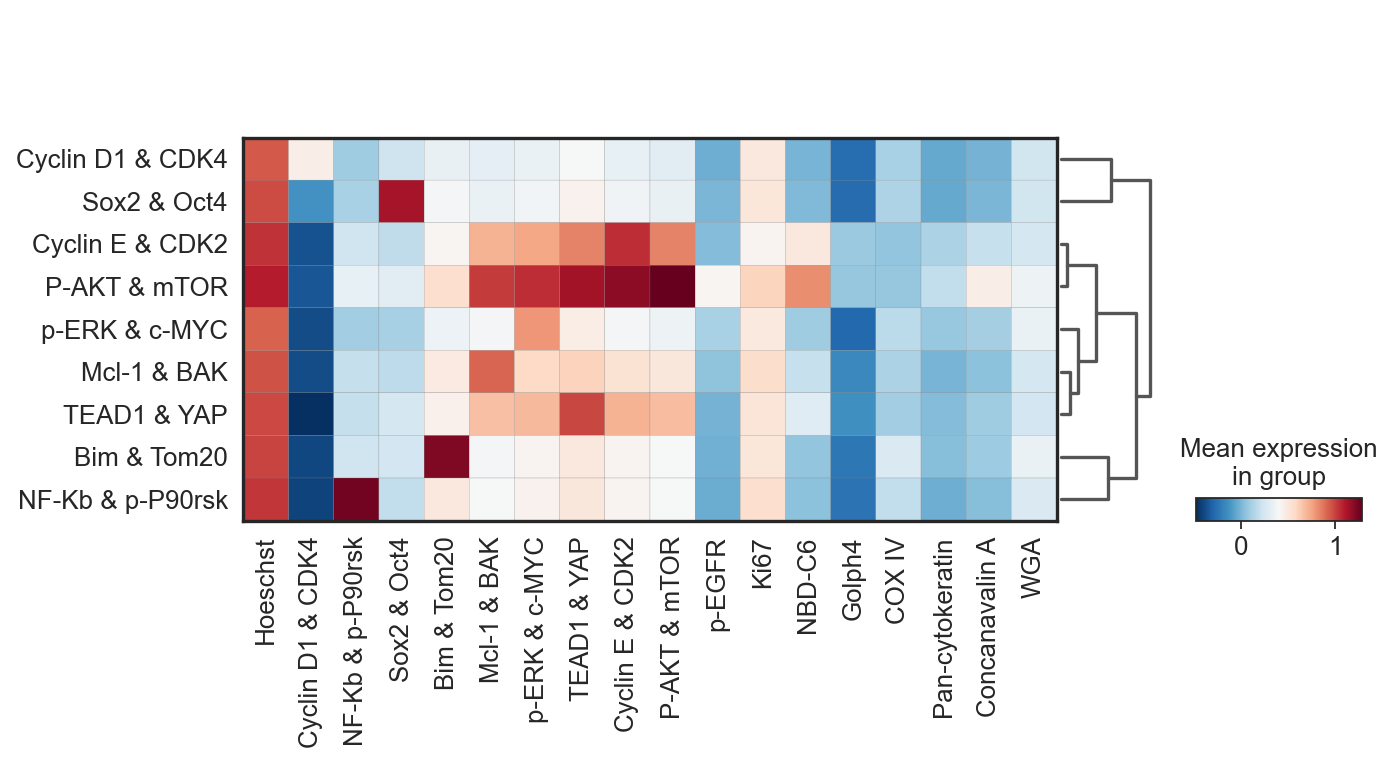

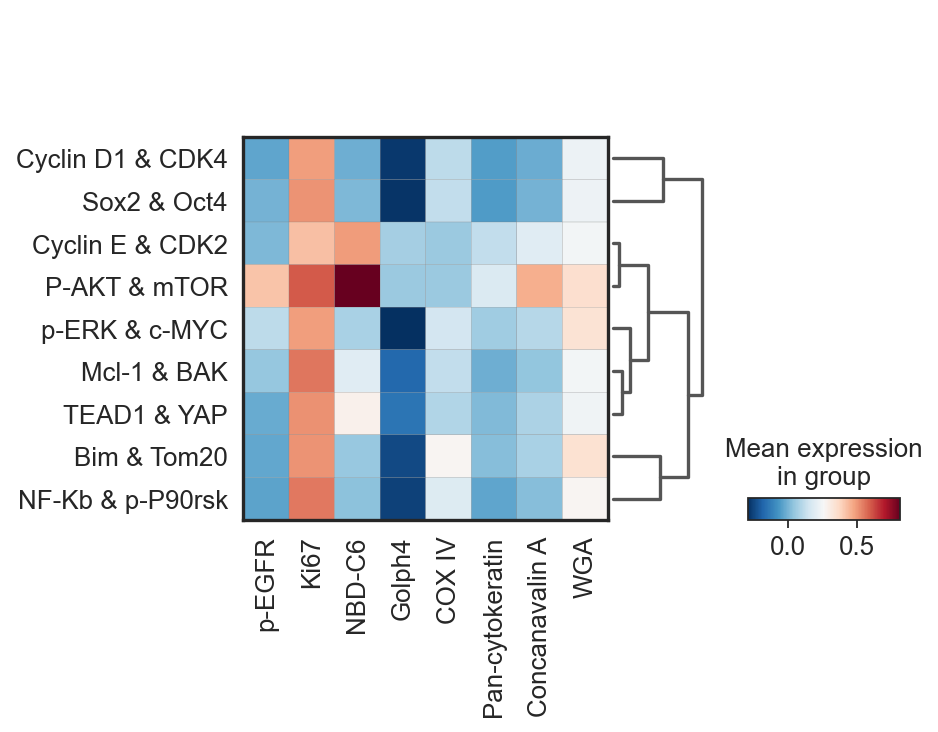

In [393]:
adata_subset = adata[adata.obs.Nuclei > 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


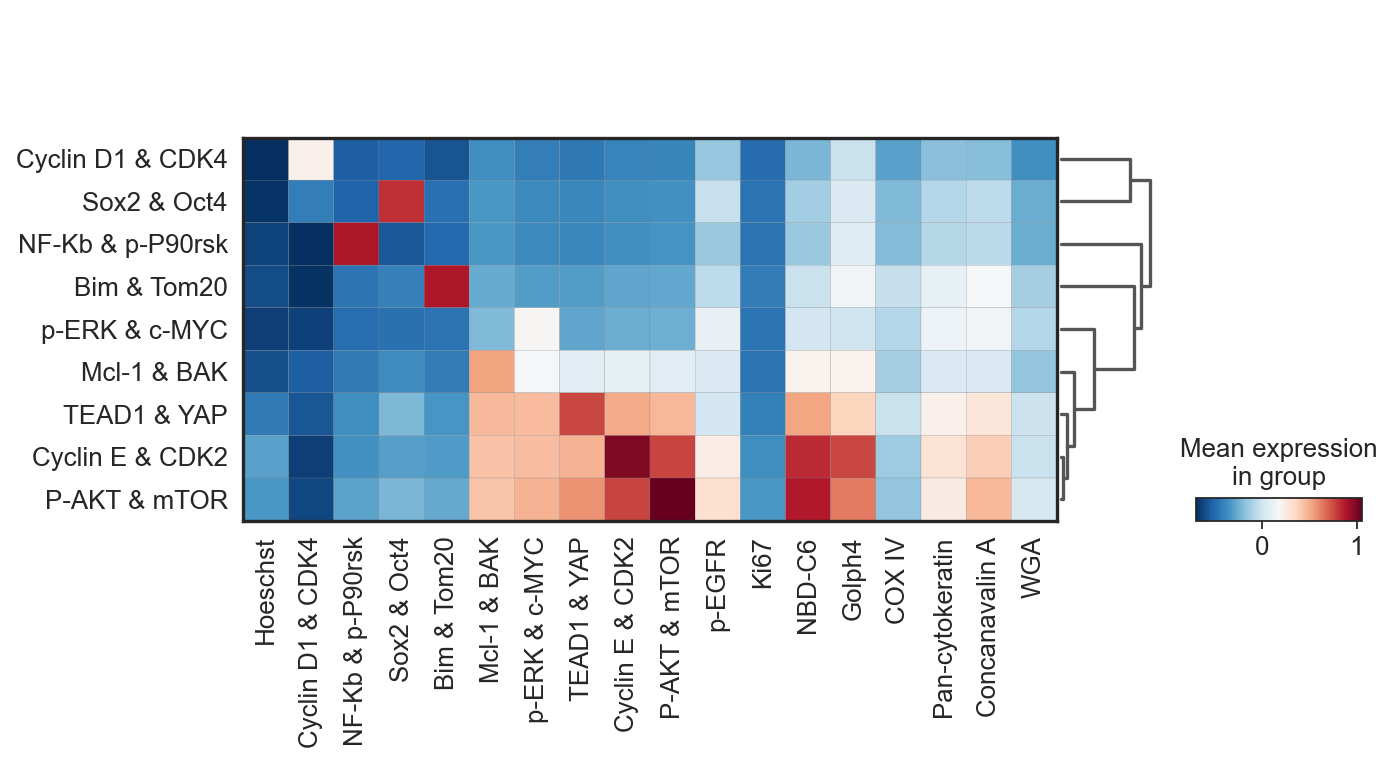

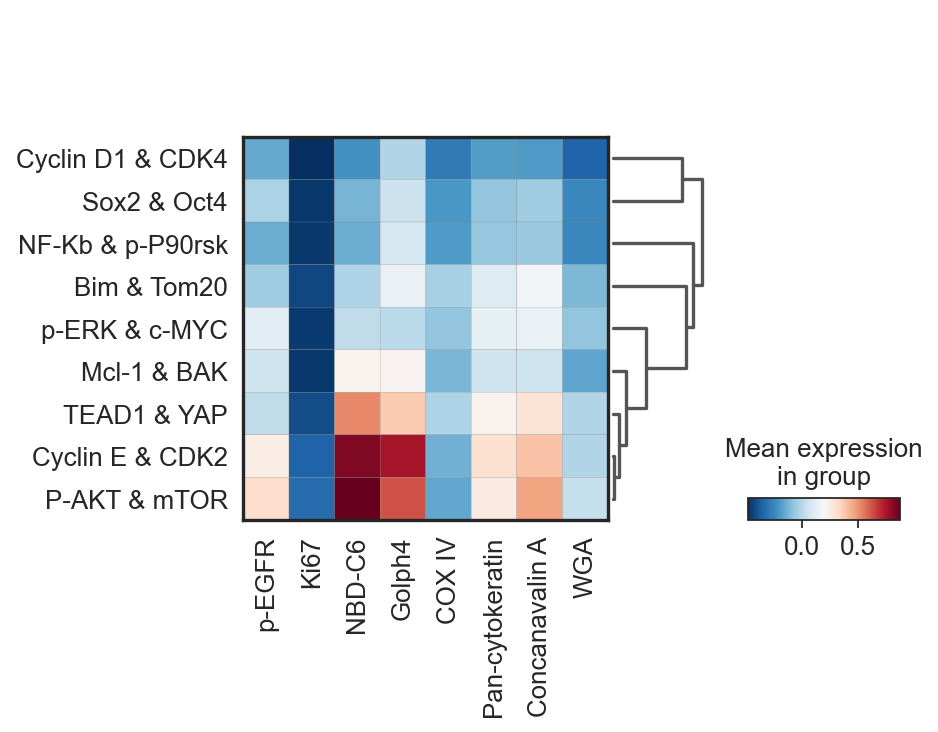

In [394]:
adata_subset = adata[adata.obs.Nuclei == 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

In [395]:
adata_high_count = adata[adata.obs.PPI.isin(['Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4', 'Bim & Tom20',
                                          'p-ERK & c-MYC'])].copy()
sc.pp.scale(adata_high_count)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


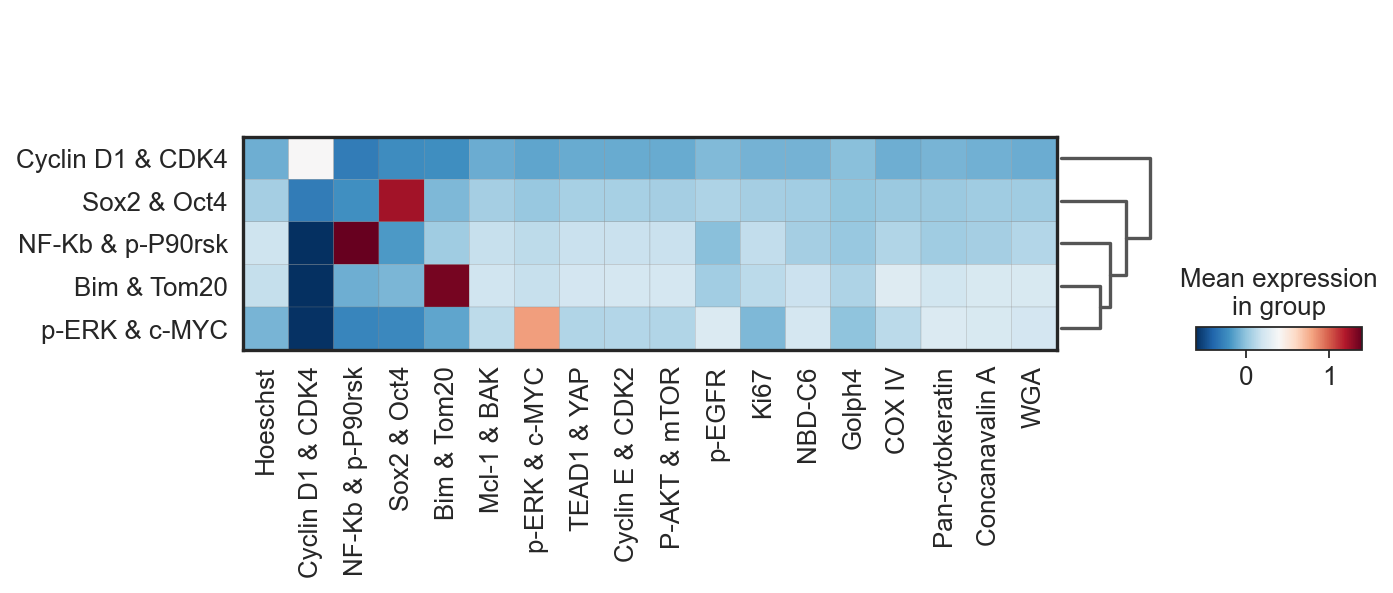

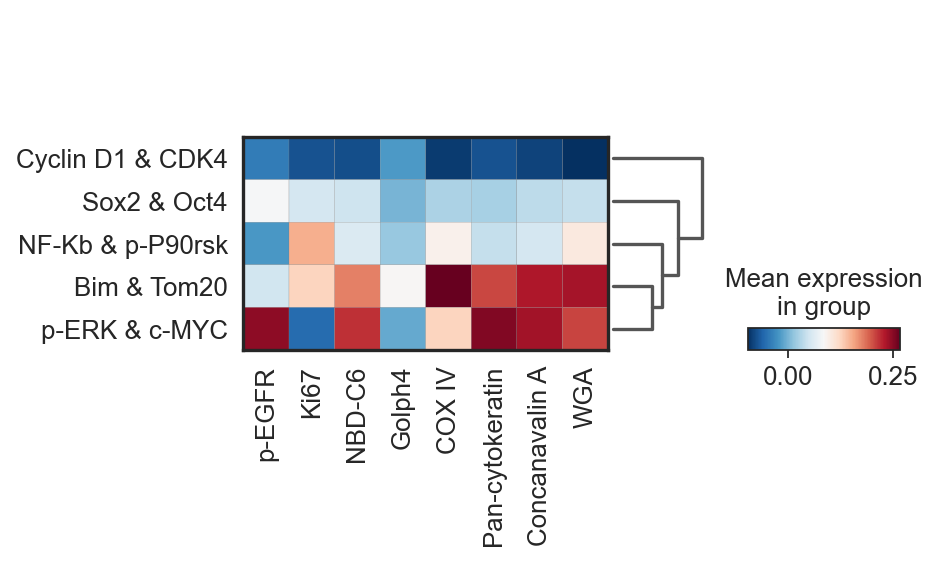

In [396]:
sc.tl.dendrogram(adata_high_count, groupby='PPI')

sc.pl.matrixplot(adata_high_count, adata_high_count.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_high_count, adata_high_count.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


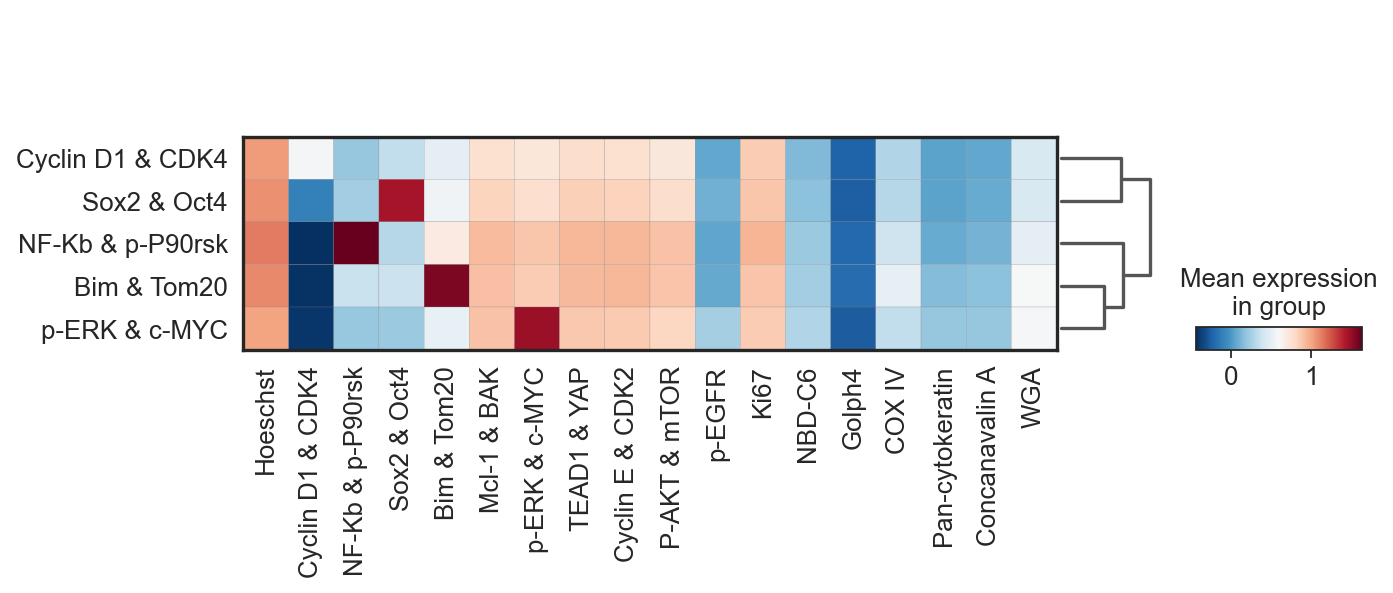

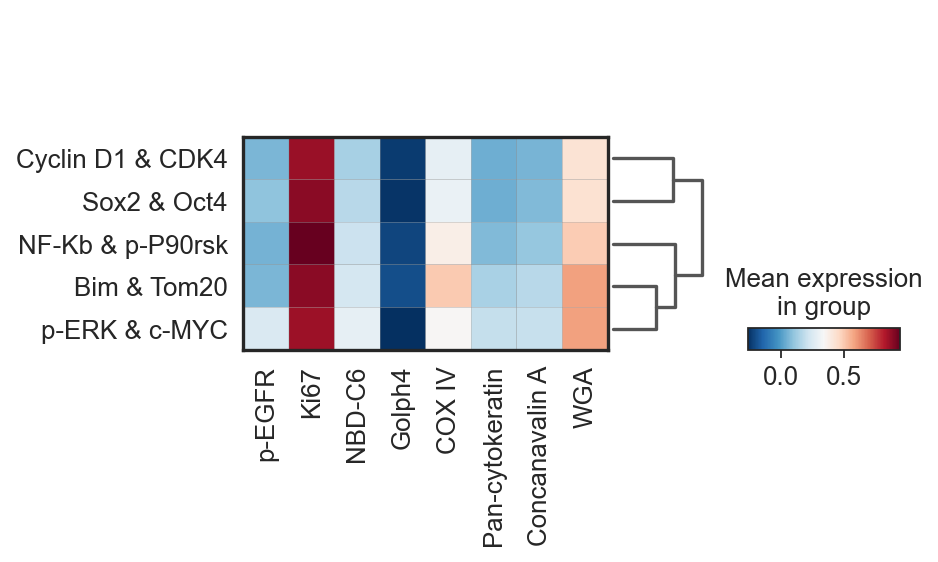

In [397]:
adata_subset = adata_high_count[adata_high_count.obs.Nuclei > 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


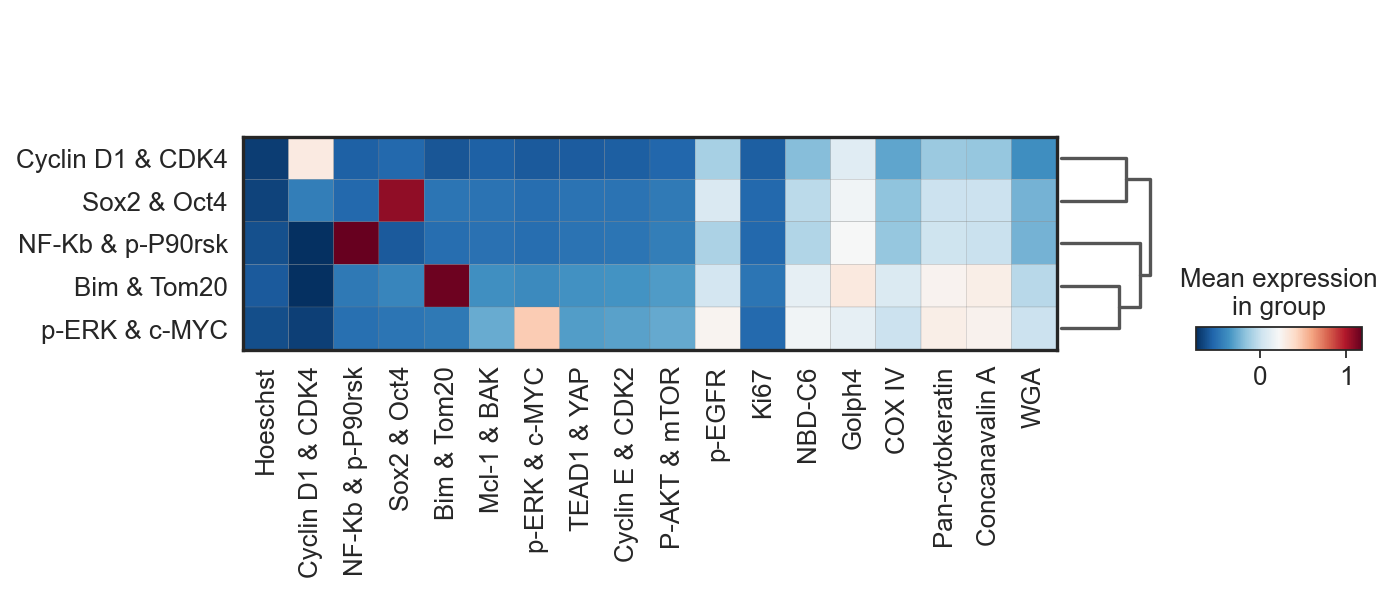

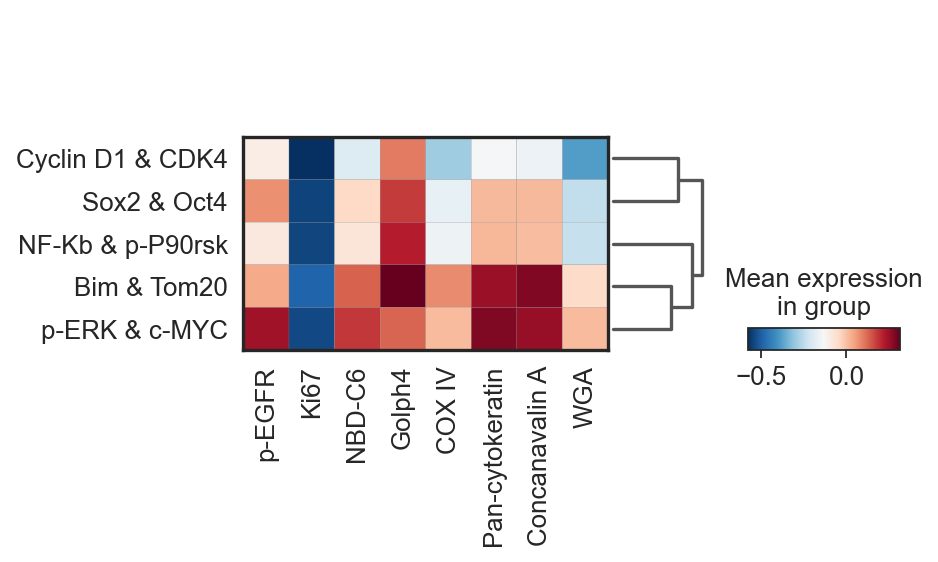

In [398]:
adata_subset = adata_high_count[adata_high_count.obs.Nuclei == 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r')
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r')

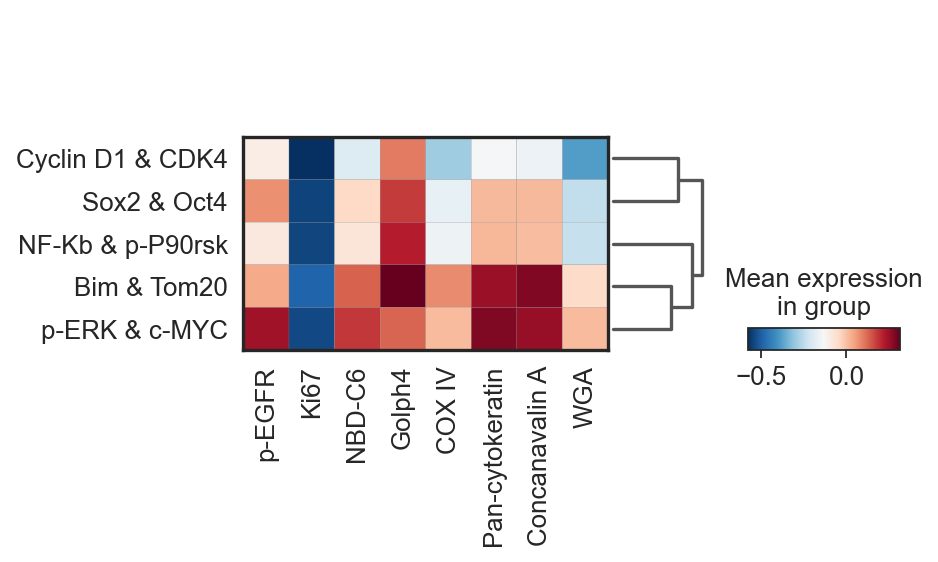

In [407]:
sc.pl.matrixplot(adata_subset, adata_subset.var_names[10:], 'PPI', dendrogram=True, cmap='RdBu_r',)

## PPI - Marker correlation

In [399]:
import numpy as np
from scipy import stats
import matplotlib 

def create_HM(
    df_per_label, my_cmap, scale_name, cellSizePixels=25, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        dendrogram_ratio=(0.1, 0.1),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Marker")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.6
    ax.ax_cbar.set_position((1.8, pos.y0, .03, cbar_size))

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

def generate_correlation_map(x, y):
    corr = np.empty((len(x), len(y)))
    p_val = np.empty((len(x), len(y)))
    for n in range(x.shape[0]):
        for m in range(y.shape[0]):
            result = stats.pearsonr(x[n, :], y[m, :])
            corr[n, m] = result[0]
            p_val[n, m] = result[1]
    return corr, p_val

In [400]:
df_exp.columns

Index(['Original Index', 'Cyto', 'x', 'y', 'PPI', 'Nuclei', 'Condition', 'FOV',
       'Hoeschst', 'Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK2', 'P-AKT & mTOR', 'p-EGFR', 'Phalloidin', 'Ki67',
       'NBD-C6', 'Golph4', 'COX IV', 'Pan-cytokeratin', 'Concanavalin A',
       'WGA'],
      dtype='object')

In [401]:
label = 'PPI'
PPI_names = ['Cyclin D1 & CDK4', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK2', 'P-AKT & mTOR']
# protein_marker_names = ['p-EGFR', 'Tom20', 'Pan-cytokeratin', 'Golph4', 'Ki67', 'NBD-C6', 'COX IV','Concanavalin A', 'WGA']
protein_marker_names = ['p-EGFR', 'Ki67',
       'NBD-C6', 'Golph4', 'COX IV', 'Pan-cytokeratin', 'Concanavalin A',
       'WGA']

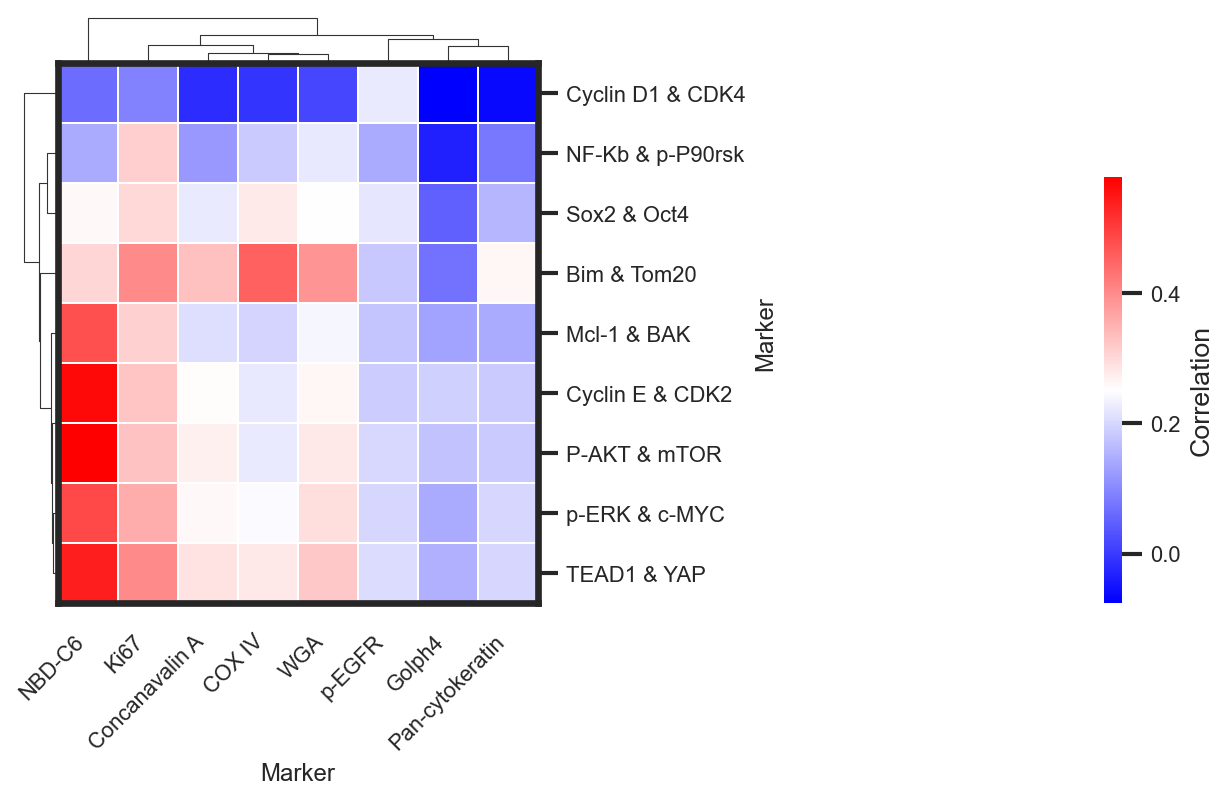

In [402]:
x = df_exp[PPI_names].values.T
y = df_exp[protein_marker_names].values.T

# Get correlation
corr, p_val = generate_correlation_map(x, y)

# Import into dataframe
df_corr = pd.DataFrame(corr, index=PPI_names, columns=protein_marker_names, )

with sns.plotting_context('talk', font_scale=0.6):
    create_HM(df_corr, 'bwr', 'Correlation', cellSizePixels=30)

('HCC827Ctrl',)
('HCC827Osim',)


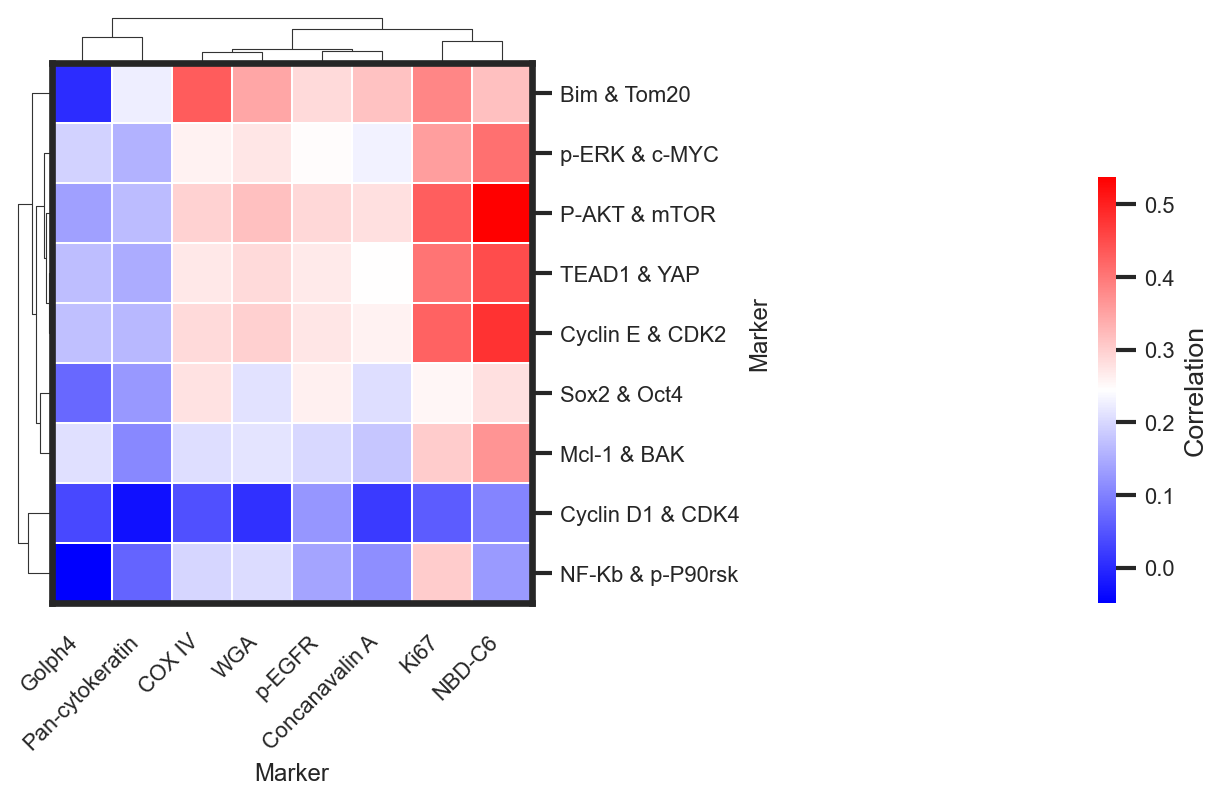

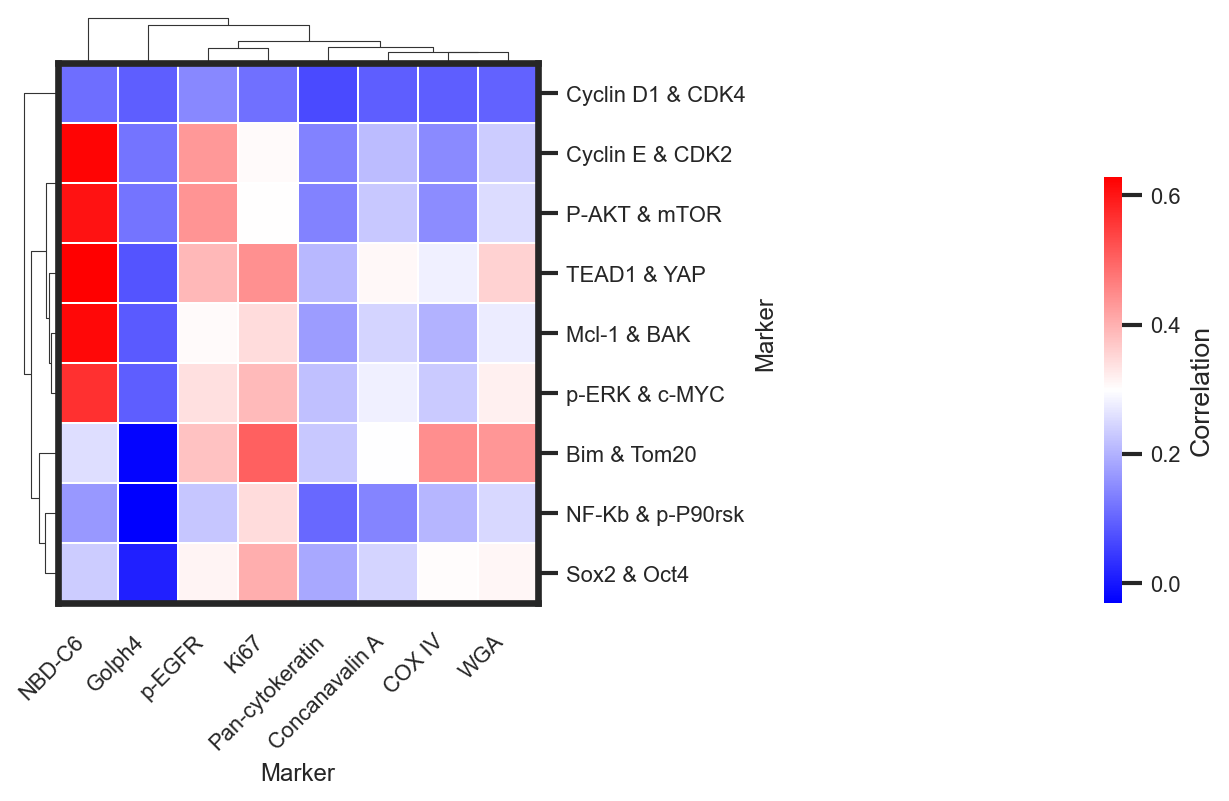

In [403]:
group = df_exp.groupby(['Condition'])
for name, df_group in group:
    print(name)
    x = df_group[PPI_names].values.T
    y = df_group[protein_marker_names].values.T
    
    # Get correlation
    corr, p_val = generate_correlation_map(x, y)
    
    # Import into dataframe
    df_corr = pd.DataFrame(corr, index=PPI_names, columns=protein_marker_names)
    
    # Create HM
    with sns.plotting_context('talk', font_scale=0.6):
        create_HM(df_corr, 'bwr', 'Correlation', cellSizePixels=30)
    